# 1. [50] Crawler

## 1.0. Related example

This code shows `wget`-like tool written in python. Run it from console (`python wget.py`), make it work. Check the code and reuse for your needs.

In [3]:
import argparse
import os
import re
import requests


def wget(url, filename):
    # allow redirects - in case file is relocated
    resp = requests.get(url, allow_redirects=True)
    # this can also be 2xx, but for simplicity now we stick to 200
    # you can also check for `resp.ok`
    if resp.status_code != 200:
        print(resp.status_code, resp.reason, 'for', url)
        return
    
    # just to be cool and print something
    print(*[f"{key}: {value}" for key, value in resp.headers.items()], sep='\n')
    print()
    
    # try to extract filename from url
    if filename is None:
        # start with http*, ends if ? or # appears (or none of)
        m = re.search("^http.*/([^/\?#]*)[\?#]?", url)
        filename = m.group(1)
        if not filename:
            raise NameError(f"Filename neither given, nor found for {url}")

    # what will you do in case 2 websites store file with the same name?
    if os.path.exists(filename):
        raise OSError(f"File {filename} already exists")
    
    with open(filename, 'wb') as f:
        f.write(resp.content)
        print(f"File saved as {filename}")


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='download file.')
    parser.add_argument("-O", type=str, default=None, dest='filename', help="output file name. Default -- taken from resource")
    parser.add_argument("url", type=str, default=None, help="Provide URL here")
    args = parser.parse_args()
    wget(args.url, args.filename)

usage: ipykernel_launcher.py [-h] [-O FILENAME] url
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

## 1.0a. How to parse a page?

If you build a crawler, you might follow one of the approaches:
1. search for URLs in the page, assuming this is just a text.
2. search for URLs in the places where URLs should appear: `a.href`, `img.src`, `iframe.src` and so on.

To follow the first approach you can rely on some good regular expression. [Like this](https://stackoverflow.com/a/3809435).

To follow the second approach just read one of these: [short answer](https://stackoverflow.com/questions/1080411/retrieve-links-from-web-page-using-python-and-beautifulsoup) or [exhaustive explanation](https://hackersandslackers.com/scraping-urls-with-beautifulsoup/).

## 1.1. [15] Download and persist #
Please complete a code for `load()`, `download()` and `persist()` methods of `Document` class. What they do:
- for a given URL `download()` method downloads binary data and stores in `self.content`. It returns `True` for success, else `False`.
- `persist()` method saves `self.content` somewhere in file system. We do it to avoid multiple downloads (for caching in other words).
- `load()` method loads data from hard drive. Returns `True` for success.

Tests checks that your code somehow works.

In [176]:
import requests
from urllib.parse import quote

class Document:
    
    def __init__(self, url):
        self.url = url
        
    def get(self):
        if not self.load():
            if not self.download():
                raise FileNotFoundError(self.url)
            else:
                self.persist()
    
    def download(self):
        #TODO download self.url content, store it in self.content and return True in case of success
        try:
            req = requests.get(self.url)
            self.content = req.text
            return True
        except Exception as e:
            #print(e)
            return False
    
    def persist(self):
        #TODO write document content to hard drive
        try:
            persistFile = open(str(self.url).replace("/",":"),'w+')
            persistFile.write(str(self.content))
            persistFile.close()
        except Exception as e:
            #print(e)
            pass
        
            
    def load(self):
        #TODO load content from hard drive, store it in self.content and return True in case of success
        try:
            loadFile = open(str(self.url).replace("/",":"),'r')
            self.content = loadFile.read().encode('utf8')
            loadFile.close()
            return True
        except Exception as e:
            #print(e)
            return False

### 1.1.1. Tests ###

In [177]:
doc = Document('http://sprotasov.ru/data/iu.txt')

doc.get()
assert doc.content, "Document download failed"
assert "Code snippets, demos and labs for the course" in str(doc.content), "Document content error"

doc.get()
assert doc.load(), "Load should return true for saved document"
assert "Code snippets, demos and labs for the course" in str(doc.content), "Document load from disk error"

## 1.2. [10] Parse HTML ##
`BeautifulSoap` library is a de facto standard to parse XML and HTML documents in python. Use it to complete `parse()` method that extracts document contents. You should initialize:
- `self.anchors` list of tuples `('text', 'url')` met in a document. Be aware, there exist relative links (e.g. `../content/pic.jpg`). Use `urllib.parse.urljoin()` to fix this issue.
- `self.images` list of images met in a document. Again, links can be relative to current page.
- `self.text` should keep plain text of the document without scripts, tags, comments and so on. You can refer to [this stackoverflow answer](https://stackoverflow.com/a/1983219) for details.

In [178]:
from bs4 import BeautifulSoup
from bs4.element import Comment
import urllib.parse


class HtmlDocument(Document):
    
    def tag_visible(self, element):
        if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
            return False
        if isinstance(element, Comment):
            return False
        return True
    
    def parse(self):
        #TODO exctact plain text, images and links from the document
        soup = BeautifulSoup(self.content, 'html.parser')
        self.anchors = []
        self.images = []
        
        #anchors
        for h in soup.find_all(['a', 'iframe', 'form']):
            if h.has_attr('href'):
                value = h.attrs['href']
            elif h.has_attr("src"):
                value = h.attrs['src']
            elif h.has_attr("action"):
                value = h.attrs["action"]
            else:
                continue

            url = urllib.parse.urljoin(self.url, value).replace(' ', '%20')
            text = h.string
            
            if url.startswith('http') or url.startswith('https'):
                self.anchors.append((text, url))
            else:
                pass
            
        
            
        #text
        texts = soup.findAll(text=True)
        visible_texts = filter(self.tag_visible, texts)

        self.text = u" ".join(t.strip() for t in visible_texts)
        
        # images
        self.images = []
        imgs = soup.find_all('img')
        for img in imgs:
            if img.has_attr('src'):
                img_url = urllib.parse.urljoin(self.url, img['src'])
                self.images.append(img_url)
            else:
                pass

### 1.2.1. Tests ###

In [179]:
doc = HtmlDocument("http://sprotasov.ru")
doc.get()
doc.parse()

assert "тестирующий сервер codetest" in doc.text, "Error parsing text"
assert "http://sprotasov.ru/images/phone.png" in doc.images, "Error parsing images"
assert any(p[1] == "http://university.innopolis.ru/" for p in doc.anchors), "Error parsing links"

## 1.3. [10] Document analysis ##
Complete the code for `HtmlDocumentTextData` class. Implement word and sentence splitting (use any method you can propose). Your `get_word_stats()` method should return `Counter` object. Don't forget to lowercase your words.

In [180]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/alla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [181]:
from collections import Counter
from nltk.tokenize import sent_tokenize

class HtmlDocumentTextData:
    
    def __init__(self, url):
        self.doc = HtmlDocument(url)
        self.doc.get()
        self.doc.parse()
    
    def get_sentences(self):
        result = sent_tokenize(self.doc.text.lower())
        return result
    
    def get_word_stats(self):
        #TODO return Counter object of the document, containing mapping {`word` -> count_in_doc}
        sentences = self.get_sentences()
        word_list = []
        
        for sentence in sentences:
            word_list.append(sentence.split())
            
        word_list = [j for sub in word_list for j in sub]
        c = Counter(word_list)
        return c

### 1.3.1. Tests ###

In [182]:
doc = HtmlDocumentTextData("https://innopolis.university")
print(doc.get_word_stats().most_common(10))
assert [x for x in doc.get_word_stats().most_common(10) if x[0] == 'иннополис'], 'иннополис sould be among most common'

[('и', 54), ('в', 29), ('иннополис', 17), ('по', 14), ('университета', 11), ('лаборатория', 10), ('на', 9), ('университет', 9), ('для', 9), ('с', 9)]


## 1.4. [15] Crawling ##

Method `crawl_generator()` is given starting url (`source`) and max depth of search. It should return a **generator** of `HtmlDocumentTextData` objects (return a document as soon as it is downloaded and parsed). You can benefit from `yield obj_name` python construction. Use `HtmlDocumentTextData.anchors` field to go deeper.

In [183]:
from queue import Queue

class Crawler:
    
    def crawl_generator(self, source, depth=1):
        #TODO return real crawling results. Don't forget to process failures
        self.doc_data = HtmlDocumentTextData(source)
        
        
        processed = set()
        processed.add(source)
        
        q = Queue()
        for anchor in self.doc_data.doc.anchors:
            q.put([anchor[1], 0])
        
        yield self.doc_data
        
        while not q.empty():
            new_url = q.get()
            
            if new_url[0] not in processed and new_url[1] < depth:
    
                try:
                    self.doc_data = HtmlDocumentTextData(new_url[0])
                    
                    for anchor in self.doc_data.doc.anchors:
                        if anchor[1] not in processed:
                            q.put([anchor[1], new_url[1] + 1])
                    processed.add(new_url[0])
                    
                    yield self.doc_data
                    
                except Exception as e:
                    processed.add(new_url[0])
                    #print(e, str(new_url[0]))

### 1.4.1. Tests ###

In [184]:
crawler = Crawler()
counter = Counter()

for c in crawler.crawl_generator("https://innopolis.university/en/", 1):
    print(c.doc.url)
    if c.doc.url[-4:] in ('.pdf', '.mp3', '.avi', '.mp4', '.txt'):
        print("Skipping", c.doc.url)
        continue
    counter.update(c.get_word_stats())
    print(len(counter), "distinct word(s) so far")
    
print("Done")

print(counter.most_common(20))
assert [x for x in counter.most_common(20) if x[0] == 'innopolis'], 'innopolis sould be among most common'

https://innopolis.university/en/
212 distinct word(s) so far
https://apply.innopolis.university/en/
1440 distinct word(s) so far
https://career.innopolis.university/en/
1938 distinct word(s) so far
https://university.innopolis.ru/en/about/
2096 distinct word(s) so far
https://apply.innopolis.university/en/bachelor/
2297 distinct word(s) so far
https://apply.innopolis.university/en/master/
2353 distinct word(s) so far
https://apply.innopolis.university/en/postgraduate-study/
2540 distinct word(s) so far
http://www.campuslife.innopolis.ru
2697 distinct word(s) so far
https://innopolis.university/en/international-relations-office/
3622 distinct word(s) so far
https://innopolis.university/en/research/
3678 distinct word(s) so far
https://media.innopolis.university/news/webinar-interstudents-eng/
3879 distinct word(s) so far
https://media.innopolis.university/news/devops-summer-school/
4071 distinct word(s) so far
https://media.innopolis.university/news/webinar-for-international-candidates-

# 2. [50] Measure and improve

How do we know that search engine's quality haven't deteriorated because of our changes?

All we need is a way to ***evaluate*** our search engine. We will consider some of the popular evaluation techniques:

1. Mean Average Precision
2. 11-Point Interpolated Average
3. Normalized Discounted Cumulative Gain (NDCG)
4. pFound

<!--We will apply them in the context of ranking with language models and will compare two ways of smoothing: additive and Jelinek-Mercer smoothing.
-->

It's best to go through the [book](https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf) *chapter 8*, concretely, *8.4* to understand the key concepts of this lab. Here we will only present some excerpts from it.

## 2.1. [10] Mean Average Precision

The most standard metric among the TREC community is *Mean Average Precision* *(MAP)*, which provides a single-figure measure of quality across recall levels. Among evaluation measures, MAP has been shown to have especially good discrimination and stability. For a single information need, Average Precision is the average of the precision value obtained for the set of top k documents existing
after each relevant document is retrieved, and this value is then averaged over information needs (queries). That is, if the set of relevant documents for an information need q<sub>j</sub> ∈ Q is {d<sub>1</sub>, . . . d<sub>m<sub>j</sub></sub>} and R<sub>jk</sub> is the set of ranked retrieval results from the top result until you get to document d<sub>k</sub>, then

![](https://i.imgur.com/EGQMHVq.png)

Implement this metric in the `mean_avg_precision` function.

In [95]:
def mean_avg_precision(search_results, relevance):
    # TODO: calculate MAP score for search results, treating relevance judgments as binary - either relevant or not.
    #
    # search_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
    # note that for tests to pass, the i-th result in search_results should correspond to (i+1)-th query_id.  
    # relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]       
    
    map_ = 0
    for i, query in enumerate(search_results):
        
        mean_precision = 0
        precision = 0
        for j, q in enumerate(query):
            if q in list(map(lambda x: x[0], relevance[i+1])):
            
                precision += 1
                mean_precision += precision / (j+1)
        map_ += mean_precision / precision if precision != 0 else 0
    return map_ / len(search_results)

### 2.1.1. Tests

In [4]:
import numpy as np

test_relevance = {1: [(9, 1), (1, 2), (8, 3)], 2: [(5, 1), (9, 2), (6, 3)], 
                  3: [(9, 1), (4, 2), (6, 3)], 4: [(10, 1), (4, 2), (7, 3)], 
                  5: [(4, 1), (2, 2), (8, 3)], 6: [(2, 1), (9, 2), (4, 3)], 
                  7: [(1, 1), (2, 2), (3, 3)], 8: [(3, 1), (2, 2), (6, 3)], 
                  9: [(1, 1), (4, 2), (3, 3)], 10: [(10, 1), (7, 2), (8, 3)]}
test_results = [[4, 5, 3, 6, 1, 2, 8, 9, 10, 7], [7, 5, 6, 3, 1, 8, 9, 4, 2, 10], 
                [8, 3, 4, 5, 9, 6, 1, 10, 2, 7], [4, 5, 7, 3, 6, 10, 1, 9, 2, 8], 
                [4, 8, 3, 5, 6, 7, 2, 1, 10, 9], [9, 7, 6, 5, 2, 4, 10, 1, 3, 8], 
                [3, 1, 5, 2, 10, 6, 7, 9, 8, 4], [9, 2, 4, 10, 8, 3, 7, 6, 1, 5], 
                [3, 4, 6, 1, 5, 10, 7, 2, 8, 9], [8, 10, 4, 1, 3, 7, 5, 6, 9, 2]]


map_test = mean_avg_precision(test_results, test_relevance)
print("map_test", map_test)
assert np.isclose(map_test, 0.646, atol=1e-03)
assert mean_avg_precision(test_results[:5], test_relevance) > mean_avg_precision(test_results[5:10], test_relevance)

map_test 0.6464285714285715


## 2.2. [15] 11-Point Interpolated Average

In a ranked retrieval context, appropriate sets of retrieved documents are naturally given by the top k retrieved documents. For each such set, precision and recall values can be plotted to give a precision-recall curve, such as this one (blue line):

![](https://i.imgur.com/QnvDLAJ.png)

Precision-recall curves have a distinctive saw-tooth shape: if the *(k + 1)<sup>th</sup>* document retrieved is nonrelevant then recall is the same as for the top k documents, but precision has dropped. If it is relevant, then both precision and recall increase, and the curve jags up and to the right.

It is often useful to remove these jiggles and the standard way to do this is with an *interpolated precision*: the interpolated precision *p<sub>interp</sub>* at a certain recall level *r* is defined as the highest precision found for any recall level *r′* ≥ *r*:

![](https://i.imgur.com/GMl2rQw.png)

The justification is that almost anyone would be prepared to look at a few more documents if it would increase the percentage of the viewed set that were relevant (that is, if the precision of the larger set is higher). Interpolated precision is shown by a red line in the figure above.

Examining this information for a single query may be useful, but usually we are more interested in a composite metrics, which will score over all test queries. The traditional way of doing this is the *11-point interpolated average*. For each information need, the interpolated precision is measured at the 11 recall levels of 0.0, 0.1, 0.2, . . . , 1.0. Then we average interpolated precision over all queries in the test collection and plot, like here:

![](https://i.imgur.com/6wDmtp2.png)


Plotting a number of such graphs for different versions of search engine on the same plot helps to compare their performance.

You need to incorporate this logic into `eleven_points_interpolated_avg` function. Break it down to subfuctions as it seems necessary to you.

In [170]:
import numpy as np
import matplotlib.pyplot as plt

def eleven_points_interpolated_avg(search_results, relevance, plot=True):
    # TODO: return 11-points interpolated average over all queries. Refer to chapter 8.4 for explanation.
    # First calculate values of precision-recall curve for each query, interpolate them, and average over all queries.
    # This function is intended to use when for each query all documents are scored until the last relevant element
    # is met. Treats relevance judgments as binary - either relevant or not.
    # note that for tests to pass, the i-th result in search_results should correspond to (i+1)-th query_id.
    #
    # search_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
    # note that for tests to pass, the i-th result in search_results should correspond to (i+1)-th query_id.  
    # relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]
    # return: interpolated_avg, list of 11 values
    inter_avg = []
    interpolated_array = [0 for k in range(11)]
    for i, query in enumerate(search_results):
        
        precision_array = []
        recall_array = []
        precision = 0

        
        for j, q in enumerate(query):

            if q in list(map(lambda x: x[0], relevance[i+1])):
                precision += 1
    
            precision_array.append(precision / (j+1))
            recall_array.append(precision / len(relevance[i+1]))
            false_negative = 0
            
        for j in range(11):
            max_prec = 0
            level = j / 10 
            for r in recall_array:
                if r >= level:
                    ind = recall_array.index(r)
                    break
            for k in range(ind, len(precision_array)):
                max_prec = max(max_prec, precision_array[k])
            
            interpolated_array[j] += max_prec
        
    if plot:
        plt.plot([i/10 for i in range(0,11)], np.array(interpolated_array) / len(search_results))
        plt.suptitle('11-Point Interpolated Average')
        plt.ylabel('Precision')
        plt.xlabel('Recall')
        plt.show()
    return np.array(interpolated_array) / len(search_results)

### 2.2.1.Tests

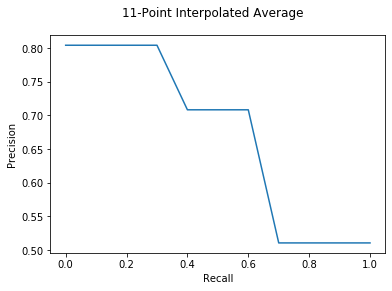

In [171]:
eleven_test = eleven_points_interpolated_avg(test_results, test_relevance, plot=True)
assert all(eleven_test[k] >= eleven_test[k+1] for k in range(len(eleven_test)-1))

## 2.3. [10] Normalized Discounted Cumulative Gain

There is also so called NDCG metric, which is designed for situations of non-binary notions of relevance. It is evaluated over some number $k$ of top search results (in our case we will evaluate over the whole dataset, since it is small). 

For a set of queries $Q$, let $R(j,d)$ be the relevance score assessors gave to document $d$ for query $j$. Then,

![](https://i.imgur.com/LLogCYa.png)

where $Z_{kj}$ is a normalization factor calculated to make it so that a perfect ranking’s NDCG at $k$ for query $j$ is 1. In other words, we divide calculated DCG score by ideal DCG score. 

Implement this metric in `NDCG` function.

In [11]:
import math 

def NDCG(search_results, relevance):
    # TODO: compute NDCG score for search results. Here relevance is not considered as binary - the bigger
    # the judgement score is, the more relevant is the document to a query. Because in our cranfield dataset relevance
    # judgements are presented in a different way (1 is most relevant, 4 is least), we will need to smth with it. 
    # The simplest is to invert it, replacing each score with (5-score). For example, if the score was 2, it becomes 5-2=3.
    # To find normalization factor for each query, think in this direction - for this particular query what would be an
    # ideal DCG score? What documents should have (ideally) been returned by the search engine to maximize the DCG score?
    # When you find it, just normalize the real DCG score by ideal DCG score, that's it.
    #
    # search_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
    # note that for tests to pass, the i-th result in search_results should correspond to (i+1)-th query_id.  
    # relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]       
    query_sum = 0
    for i, query in enumerate(search_results):
        
        sum_ = 0
        
        for j, q in enumerate(query):
            if q in list(map(lambda x: x[0], relevance[i+1])):
                ind = list(map(lambda x: x[0], relevance[i+1])).index(q)
                sum_ += (2**(5 - relevance[i+1][ind][1]) - 1) / (math.log2(2 + j))
                
        ideal_sum = 0
        k = 1
        for j in sorted(list(map(lambda x: x[1], relevance[i+1]))):
            ideal_sum += (2**(5 - j) - 1) / (math.log2(1 + k))
            k += 1
        query_sum += sum_ / ideal_sum
    
    return query_sum / (len(search_results))

### 2.3.1. Tests

In [12]:
ndcg_test = NDCG(test_results, test_relevance)
print("ndcg_test", ndcg_test)
assert np.isclose(ndcg_test, 0.640, atol=1e-03)
assert NDCG(test_results[:5], test_relevance) < NDCG(test_results[5:10], test_relevance)

ndcg_test 0.6409675295633275


## 2.4. [15] pFound ## 
**pFound** -- ranking metric invented in [Yandex](http://romip.ru/romip2009/15_yandex.pdf). This metric models user behaviour when looking at the search engine representation page (SERP). Metric assumes a user is inspecting a list from the top to the bottom. There are 2 global parameters, controlling behaviour:
- `pBreak` -- how probable, that the user will become tired and just quit at this position (`0.15` by default).
- `pRel` -- how probable the user will click the document if this document is relevant (`0.4` by default for a relevan document, `0` is given to irrelevant).

Then, to compute pFound for the exact page we do:

$pLook_i = pLook_{i-1}*(1 - pBreak)*(1 - pRel_{i-1})$

$pFound = \sum_{i=1}^{N}pLook_i*pRel_i$

Implement `pFound` below.

In [60]:
import math 

def pFound(search_results, relevance):
    # TODO: calculate pFound score for search results, treating relevance judgments as binary - either relevant or not
    
    # search_results: list of lists of ranked results for each query [[doc_id1, doc_id2,...], ...]
    # relevance: dict, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]
    # return average value for search results 

    pFound = 0
    for i, query in enumerate(search_results): 
        pLook = 1
        pBreak = 0.15
        pRel = 1
    
        for j, q in enumerate(query):
            if q in list(map(lambda x: x[0], relevance[i+1])):
                if j == 0:
                    pLook = 1
                else:
                    pLook = pLook * (1 - pBreak) * (1 - pRel)
                pRel = 0.4
            else: 
                if j == 0:
                    pLook = 1
                else:
                    pLook = pLook * (1 - pBreak) * (1 - pRel)
                pRel = 0
            pFound += pLook * pRel

    return pFound / len(search_results)

### 2.4.1. Tests

In [217]:
pFound_test = pFound(test_results, test_relevance)
print("pFound", pFound_test)
assert np.isclose(pFound_test, 0.582, atol=1e-03)
assert pFound(test_results[:5], test_relevance) > pFound(test_results[5:10], test_relevance)

pFound 0.5821558180674999


## 2.5. [BONUS] Evaluation

Now we want to apply these metrics to some simple but real search engine. Print out all metrics you've just implemented for your search engine.

Please note that the data is the same, and metrics evaluate same search engine, so their results should not vary much.

### 2.5.0. Data

There is a number of ways to evaluate a search engine, however, all of them require so called relevance judgements - human assigned scores of relevance between `(query, doc_id)` pairs. We will use Cranfield relevance judgements collection, download it from [GDrive](https://drive.google.com/drive/folders/1u6dSUqdrXsckSHmVHNNE27eDiajMWLl2?usp=sharing) or [GitHub](https://github.com/IUCVLab/information-retrieval/tree/main/datasets/cranfield_data). 

This was the pioneering test collection in allowing precise quantitative measures of information retrieval effectiveness, but is nowadays too small for anything but the most elementary pilot experiments (which is exactly what we are doing here). Collected in the United Kingdom starting in the late 1950s, it contains 1400 abstracts of aerodynamics journal articles, a set of 225 queries, and exhaustive relevance judgments of all (query, document) pairs.

![image.png](data:image/png;base64,%20iVBORw0KGgoAAAANSUhEUgAAA70AAAFXCAYAAABunSlhAAAgAElEQVR4Aey9z2vsTnb/rf2Y+Vtmq1W8zB/ysRbx7ru7s/H1YhYJTxpseLx4DLMMDnj3uWkMAYMhYb5JhnhlLmkz5BcY7MAsMoFJGMJ5OPVDOjqqkqolVbe6/b7g22pV1TmnXlXq0ltVkgrCPxAAARAAARAAARAAARAAARAAARA4UgLFkdYL1QIBEAABEAABEAABEAABEAABEAABqkXvH/3xrwl/YIA+gD6APoA+sOQ+kHvcXnLdERuOTfQB9AH0AfQB9IH0PiDPGVqiVyZgGwRAAARAAASWRIAH+tz/duEjdx1gHwRAAARAAAQ+OwE9nkP0fvYegfqDAAiAwIEQ0ANYjrB34SNH3LAJAiAAAiAAAiDQENDjOURvwwZbIAACIAACCyagB7Acoe7CR464YRMEQAAEQAAEQKAhoMdziN6GDbZAAARAAAQWTEAPYDlC3YWPHHHDJgiAAAiAAAiAQENAj+cQvQ0bbIEACIAACCyYgB7AcoS6Cx854oZNEAABEAABEACBhoAezyF6GzbYAgEQAAEQWDABPYDlCDXZx2ZNVVlQUa1zhAGbIAACIAACIAACEwjo8RyidwJMFAUBEAABENgdAT2A5fCc6mOzKqlcbXKEAJsgAAIgAAIgAAITCejxvF/04kr2RNwoDgIgAAIgMBcBPYDNZVfaSfUB0SupYRsEQAAEQAAElkVAj+e9oheD+rIaD9GAAAiAwGcmoAewHCxSfWB8zEEfNkEABEAABEBgHgJ6PIfonYcrrIAACIAACGQmoAewHO5SfUD05qAPm5+GwL+/0Q9//Gvi483//eJX+Wv/N3/2a/qjP3mjf83vCh5AAAT2TECP5xC9e24QuAcBEAABEEgjoAewtFLb5UrysV5RWZS0xi2928FFbhBgAr/6Df3RH7/QX/y7wOFE8C6Er/CKTRAAgSMmoMdziN4jbuymar+nv/iT5moqdwL+O9bB5V//8oX+6M9+21QfWyAAAkdBQA9gOSqV6gMzvTnow+bxE/gt/SJy/mHG7noW1p63tM5TWCzX6UxKn9v8hv6mBsh+Xugv/pIFNp/z2DQz09s6P+izQWRiqmejlVCvfWEDBEBgiQT0eB4XvbiSvcT2GxmT/VH/4S9/35Q3V1p/Ta19TepBb0H0HnTzIXgQiBLQA1g044SEVB8QvRMgo+jnJWBmdCPisZU2LHq1gG2LZiuuvdj1wHUZ/b1lw8QjhbS3gk8QAIFDIKDH87joJSIM6ofQpCkxBkQvFzPCV/6g91/xJLf8iDsR/9krsEMDE6fzAOcHIH/FVfrSA6BM8/l9Pb0/ac+X1+UaUY+rtZ4fPkHgcAnoASxHTVJ9YHzMQR82j55A57xD1Hgb0dvK62242V2zbNqeI7RmiomoJXKHbLhzHm3De8MnCIDAsgno8Ryid9ntNVN0Vgx2Z3XloOAEo1j2Y4WiF8U2b2Pjt/QLs8zIi1ARamsJkhei3o7/7kWzWz4kliy1BiXS6b68F7pqEPP5RT2sWPf+RZzYBAEQOCgCegDLEXyqDyN6q3WOEGATBI6XQFBouuq20gbOLZwg5eO1/efPDeT5TYOzdX4xaINIXuxvzn8ae9gCARBYLgE9nkP0LretZozMDh7dH2wxKJgffy0MOd0NINGrswMDk7vnRl4pNWJailJpuzXoeQQijoA9M2MtRHPHvhvYZAzeMj5BAAQOh4AewHJEnuwD77HPgR82j56AOO9QdTVjdz2WD5xbBM9ZpMGwn67o1ec90obcDtuTObANAiCwLAJ6PB8WvbiSvawWHBVNguiVwrP2IQad1uxtnaF+kERLULbyChuuWEeUSt9OoHJHbf/5q7dde4Oil/0Ku13xL+uDbRAAgaUS0ANYjjh34SNH3LAJAodCwJwD+AvqPmhzHtCsAOPdXYEqXzcUO6/xBsMitWXTXURPOycInHt4V/gEARBYJAE9nveKXsKV7EU24vZBRQaHjtjUVzx50NjHTK+OQ9Y4MPC0RLZbDi1nkmVxCg+ErSz4AgIgsEgCegDLEeQufOSIGzZB4JAIWOGrL27rZ3jY8ZqPSfNAKjXWd5/eLEVxeKxvi14mZs8prA8Xj59tdkK8ToueVxwSecQKAp+HgB7P+0Xv5+Fy5DUNiF4389lc4XQ//OJHvb3UyA4gTX5/T2/a1Vg5E9w70zt45TVR9PpBq9OygfKdPNgBAiCwRAJ6AMsR4y585IgbNkHgKAg4oSnPGY6iXqgECIDAzgno8Ryid+dNsA+HTtC2lgz75cIyHnlVVV4xdXnEEuH2i+Vlud/Q37SuxnZFZr/oZV+BeGsR27Wnlzd3ljLjaq1sZGyDwMES0ANYjoqk+Hh7e8vhGjZBAARAAARAAARmIqDHc4jemcDCDAiAAAiAQF4CegDL4S3FB0RvDvKwCQIgAAIgAALzEdDjeVT0YlCfDzosgQAIgAAITCegB7DpFrsWUnxgfOxywx4QAAEQAAEQWBIBPZ5D9C6pdRALCIAACIBAlIAewKIZJySk+IDonQAYRUEABEAABEBgBwT0eA7RuwPocAECIAACIDCdgB7AplvsWkjxAdHb5YY9IAACIAACILAkAno8h+hdUusgFhAAARAAgSgBPYBFM05ISPEB0TsBMIqCAAiAAAiAwA4I6PEconcH0OECBEAABEBgOgE9gE232LWQ4gOit8st+57XR7o8+ULVT39Otw/ZvWVzsNkQrVdEZUlUVNncwDAIgAAIfHoCejyH6P30XQIAQAAEQOAwCOgBLEfUKT6mid4Xuj35QpfX70QPd3R2ckXfXnPU5BhtWnZ5Re+O2mdNVK6OsY1QJxAAARBYBgE9nkP0LqNdEAUIgAAIgMAAAT2ADWQflZziYw7Ra4SbEb139Dwq0s9YaHeiN3v7QPR+xg6MOoMACOyQgB7PIXp3CB+uQAAEQAAExhPQA9h4S/GSKT6mid53+nbqZnfNkl0lel8f6fbULuM9O72jb9d3Zknv2ckX+vozt//8xVTg+dx9l7PFry91eV4KfHl6R89+JlksET47f6G36ytn+4p+3FhByWXq2WeZ/0TFGUBYx3P+SN/OnW2ug/HP9Y7H/+MvbT3Zv4/h0uc/faQ348/Nwp5e1UudDSNfP84zsv7NbPtA+7CPzYrKoqCirGgT4JC0C6I3CRMygQAIgMBYAno8h+gdSxLlQAAEQAAEdkpAD2A5nKf4mC56vYBkgeoFHQs2e9+qWfrMlWMBd/KlEaFExMKSBWv9Ty6RduVvH95d8js9X1/RmRKstTh1+1n8XrLNBys8a//enypf+w5smPhYhLsY2Lb03xe/zcsXBKxAPjNs5Oxul0dTpuE3uv6mPuw70j6+vhC9ngQ+QQAEQGCxBPR4DtG72KZCYCAAAiAAApKAHsBk2lzbKT6mid54pEbASRFMZGZj65lXL0IjopfL+5lS/Snvg7XC1Au7djytNC3C21mD3/pELRfoS7cCluNyotfUsyt6pSgnkXeO+gcrlWMnZnpzUIVNEAABEKgJ6PEcordGgw0QAAEQAIElE9ADWI5YU3zsUvTqh131icaWYO2B07Eh8wqhm2pPFu/YljPRmUVvarydGGUFdrUN0bsr0vADAiDwSQno8Ryi95N2BFQbBEAABA6NgB7AcsSf4iOX6E1e3uxng1/f6fmclw/Le4Tt8md7D+w7vT3cmftfOzO9crZYgbTi0d43255VVRkDXzuCMiR6I/GnzvSa5dLuPl6uH89qm/o5wW7uVzaxjat/oFrtXX55c5Hpnt51RUVRULkafcdwO158AwEQAIFPSECP5xC9n7AToMogAAIgcIgE9ACWow4pPrKJXq6QeJAVi7nLUyFqTYWbB1XxQ5ye6wddueXKqvwZP/SJH1rFZZ1A1EufW/cIuxj4nbjyXlzjeuA/Frzetrkf14lQ3tfYCsf/w0/+VJS9qx/GdXn9aO5r/uEnv6D/49/Ty/v8Q65Orqi5h7fLb1T9B+o55UFW64qoKNRf2Xa4rgoqiorW7d34BgIgAAIgsAUBPZ5D9G4BD1lBAARAAAT2R0APYDkiSfGRVfTqSqmZUp2c5btY4pzFPoz2ENhQhVneHj5IAgEQAIE0Ano8h+hN44ZcIAACIAACeyagB7Ac4aT4OHbRa5c3hx90lYM5bAoCZuk0ZnkFEWyCAAiAwCgCejyH6B2FEYVAAARAAAR2TUAPYDn8p/jYjei1Ty32y4X5U96XO3/d2/7s64Lm9wKLIAACIAACILALAno8h+jdBXX4AAEQAAEQmExAD2CTDQYMpPjYjegNBIddIAACIAACIAACSQT0eA7Rm4QNmUAABEAABPZNQA9gOeJJ8QHRm4M8bIIACIAACIDAfAT0eA7ROx9bWAIBEAABEMhIQA9gOVyl+IDozUEeNkEABEAABEBgPgJ6PIfonY8tLIEACIAACGQkoAewHK5SfED05iAPmyAAAiAAAiAwHwE9nkP0zscWlkAABEAABDIS0ANYDlcpPiB6c5CHTRAAARAAARCYj4AezyF652MLSyAAAiAAAhkJ6AEsh6sUHxC9OcjDJgiAAAiAAAjMR0CP5xC987GFJRAAARAAgYwE9ACWw1WKD4jeHORhEwRAAARAAATmI6DHc4je+djCEgiAAAiAQEYCegDL4SrFB0RvDvKwCQIgAAIgAALzEdDjOUTvfGxhCQRAAARAICMBPYDlcJXiA6I3B/mpNje0uimo+FpQcb+eaixv+Y8VlRcFlU+bcX6i5QWDnByi/sdVJ73UjuqXHtDh5HRtxsdH9X0PYe/bf6DKm6fS/l5clLT6CGTYapfom0v//dmqXoedWY/nEL2H3Z6IHgRAAAQ+DQE9gOWoeIqPaaL3hW5PvtDl9TvRwx2dnVzRt9ccNcllM3f8a6q8IPxeUbHlCen6frroncNGL/2pojGhfNY6DPjP6tuB3YWP3jbcY+L4uttjay+i1/Dat/9Ao434jQlYqXeNb5vaxMFvLImBHs8PV/S+PtKlP3Ho6SJv11dU/fTnizqx2GyI1iuisiQqqp7gkQQCIAACIFAT0ANYnTDjRoqPOUTv7QM50XtHzzPGn9+UFb354hcnxuaEtKJt5m3nOOEyNm5WNHIeNn8TJHiYg0OCm2CWXfDbZ/2Cld7hzvF8xbG1w3gbV/v230RSb0H01ijm2hjfP+eKoLGjx/OFit6EK8mJotdUvXM1PcF+wyzf1pqoXOUzD8sgAAIgcEwE9ACWo24pPqaJ3nf6dupmd804pkTv6yPdnn6xF2tP7+jb9Z27cPuFvv7M7T9/MVV/Pnff5Wzx60tdni/4Xp7e0bOfSXbjprkQfP5C8qLwjxs7LrYuEsv8Jz7Ogfg5ss2KyqKgoqxGCEdeJuiWG5oZRS967QmzWb584feJJYVuRtiKoRWt7t3SxZuK1mLpIi9p5KXFxs7Xgsp7KW6FD14e7P+2Wa74sabKL7P25WsBLeLVy4/55Nvn58+LkkpvJ6W8OhhiorC3/m4G18Rxv6bu8s+e+I3/Pn4izc/eS391m6qKRL5uXz/pP95/qLf9IsHw7oH2+ycS7Fx/MnVwbV0vr+31L+og+0py/7TlyxtxDNxU7aW9yn+pjp8eAjbpY90ce+74ao6/Kf5F3fv6z1D8H6vW8cks0laTSP/x/jP0+6P7l+Rb94f79u9X3TcG4XOGTYu/OZY9L07uaZ8k/4qvsV//PglGof4pj3f1+/Ln74nHR2/9updH9Xi+aNE725XkiOidzX5SRwxkgugNQMEuEAABEAgT0ANYONe0vSk+poteLyBZoD7Smw9ZX8xlAXvypbVSiYXumRO9ppgc31z524d3Z/Gdnq+v6KwWrHZ3I5ZtHCx+L9nmgxXYZum1s2D8tcqz6I3E78pMF73+pJIFpBCltQh2J0gmzZ5o+SWb5sStPsnbkD0J7Z4M2VCtHX1vrSkj/fp6DX7KuDgz+y+pCNgKxWVEpold2mnXz4cQKu/T+HMo3ebtqb8RY7YdjFBWwqrPvkkL1NkLQ8nb5N1S8I6u32D/kdzZS7z9LL/2/ynt1+HWmmlM8x/l2w4n8M2Jkvr4IHthw393oqT67tc4bGjN970mt4+zz4LGeHfHX11+on93YSHaf4bid+l1eRZwfAHM1z9ArLVrsP+44662p35/huLzxy2Xd21g+5T/PWxFE/jS9J/6QkOrfw21j4g/6L+x37Rv9/dtqH+a9MjvS+rxEa5fF4kezxcqevuuJHOavbrtr1Z3qimulNsr3Tzoy/um+ux3rIV3TLqS7UxC9IbZYi8IgAAIBAjoASyQZfKuFB/TRG88RBafZ1IEE5nZWDl+9YleP3PL457+Mxd5neuukG1iaqVpEd5k29OWPWmrnuyDoMzJ6hPf99ucFOqTJnPSKATY5vuqmUF1sxH1SbCr1dBJW1/ljUjwsxw8o3a/as00+7I6Tt7fnOC6k0sjNF2d1cOHQuW9bf6MpSfXXzCVdv12zH7tWzD3Zeo0b1uLEJlxYDvmv79+Cf3HP9yI27Cn/ULhpbRfJ+6WKCErMgf6j7ER4RuKq9ln69/u701fM/F73+rTX1RqbAW2TF2aY9HmkP13un9T90j/GYrfpGtuin+gVmJXQv9RzxSQPofiY0dD/UME0900x5N+KBfH7PYNts+w/5Tft6H+2WpDVYve+g/VT9nir3o8X7DoHbiSTESdwZ9rqAfpwJVyooQr1QF4rV0QvS0c+AICIAACuQnoASyHvxQfuxS9+mFXnXFPzPS2BGsPnI4NmVeMoan2ZPG82+4EnU/IefmvX6YsTmT1SZM86fQzjVX91GRrry0C3ImfsLltnTYfa1o/VVTduxj9SbowpOPkJBOrydsIESIpGhoDofJNauDklRP5pJef3ptSfzWzK23zdp9/kxbjJ4SuyRdgo32Fvgf9D9ZvuP+wr5T2C8WU0n6duAOia8h/L99QYPW+ftE5pT2Mix5RZY+xGfz39J+h+IPcAvxrXJ2N4f5jfIhjR/7+DMXH7nR5c8x60dqJR+0IikKRZ7B90vxP7Z+dOooQO2myfYbqJ+z4TT2eL1T0+nD7P0MDd+hKuT5p6Le6w1TM9O4QNlyBAAgcOgE9gOWoT4qPXKI35aKtGff8bPDrOz2fi5VMTrDy8me7ZPqd3h7uzEMfOzO9com0AmnF7lXSwyJVUfvVXxQuxtzTG7RY7zQnkXyv4NOmuedUnGTqkyZ50mlPIP09jLx0swq+OsjYqEVbWBjXAbU2vED1y0NZyLZnon12HSfvTxFNfeV9Gn+G7G9Vf8FU2vXbQfsucYifSXcXLfQFB29/6DPo353U23sgw+3b33/S2y8UX0r7tdh8uOXTtahJ89+y4e4VTuNo7ZuVEe4+9w0z868xcoKSX/nll69yOl9cSprpdRdoZHnb1n72dx7/1qa9oNSq91D8dV3d8cn3t/J98zX/UKu29/X3n+5xZ/L735Kh+ELHrRR97VAC3xzfuv04C/9+le71aDpdLz/vxt8W3bZ8s/w9/Ps21D9NeuT3pVU2cnw0/UvXr4tEj+dHJ3pbJwS+/uJKuN+1iE+I3kU0A4IAARA4DAJ6AMsRdYqPbKKXKzR4e07zoKozvre2ftCVWx2lyp+d2vt1jQh29+zqpc+te4RdDPx2BH0vcDJvL3pHPchqwIs8CXQnkf6E3Jww+WWZ8kEpvO9mRfwwIXOPrZsp5mXS9UOnWidh4mFULM5aD7vqi8+dVPoYjF8vsl05d+JtHgAj8p39tXiQ1U1Vx1VyjPK+w0h5wyCSVouaofrHyks2kTy+DWwtB/j5k/9tZ3kjvpPrx8GxDS9yVP/xs+qtttEPeoo1v4ytr/1YGNYPKKvMhRfj76Kiv/KiUfSLIuhf2Ejtn565mekX/f6iJCliSD3oyS7x9iI4Vnmx3whJ9xA5vjjlH4Q1p39vK9R/BuJvLX9ntnxRyvFu92FRJ7nZ03+Gfn+M1O6Jr1WehbKvJ8cXqquMy28r/ly31u+XSq/bxwtu3/cC/if3T3mMeD/8KX9feo4P82QGFX+nfp6D+9Tj+dGJXv8gjvpBHq8v5h5geU+UYjLuqx/Up1zJ7hO964qKoqBy1VwxHhcoSoEACIDAcRDQA1iOWqX4yCp6daX2cdFWLHHW4eA7CEwm4E7mW7N0k43CwKchgP7zaZp6akX1eH6Yojdytdov33p7eKTLwCsf+Oq2zzMV5JSnU64roqJQf2U7onVVUFH4JSHtNHwDARAAgc9IQA9gORik+Dh20WuXN/vnauSgDJufmYCZ0UqdufrMoFD3IAH0nyAW7AwQ0OP5YYreQMWOa9eGKszyHleTojYgAAKTCegBbLLBgIEUH7sRvc17c/1y5Nku2gbqTdT2p58iHSyCnSCQTEAt/fb3OSaXR8bPTQD953O3/7ja6/Econccx7ylzNJpzPLmhQzrIAACh0ZAD2A54k/xsRvRm6N2sAkCIAACIAACn4OAHs8hej9Hu6OWIAACIHDwBPQAlqNCKT4genOQh00QAAEQAAEQmI+AHs8heudjC0sgAAIgAAIZCegBLIerXfjIETdsggAIgAAIgAAINAT0eA7R27DBFgiAAAiAwIIJ6AEsR6i78JEjbtgEARAAARAAARBoCOjxHKK3YYMtEAABEACBBRPQA1iOUHfhI0fcsAkCIAACIAACINAQ0OM5RG/DBlsgAAIgAAILJqAHsByh7sJHjrhhEwRAAARAAARAoCGgx3OI3oYNtkAABEAABBZMQA9gOULdhY8cccMmCIAACIAACIBAQ0CP5xC9DRtsgQAIgAAILJiAHsByhLoLHznihk0QAAEQAAEQAIGGgB7PIXobNtgCARAAARBYMAE9gOUINcXHuiqoKPEu9Rz8YRMEQAAEQAAE5iCgx3OI3jmowgYIgAAIgEB2AnoAy+Ew1QcL32qdIwLYBAEQAAEQAAEQmEpAj+cQvS2i7/Tt9AtVP/05nZ2/tFI+xZePFZUXBRVfC6q+L7PG63sbX3GBWZZlthCiAoF8BPQAlsNTqo/NqoTozdEAsAkCIAACIAACMxDQ4/lCRe8L3Z58ocvrd6KHOzo7uaJvrzPUXph4Pv8SFbZ9acLEhM389esPbk3VRUHl04boe0XFRUmrD1/Cpi1V9HKUm6eSjlv09rWPbyd8gsDnI6AHsBwEUn1A9OagD5sgAAIgAAIgMA8BPZ4vWvTePpATvXf0PE/9aytG2J4+0lu9p9nYlejNWb+mNqEtIWyN6JWzpiItVHQB+z6L6DUXHjrts4AGQAggsCcCegDLEUaqD4jeHPRhEwRAAARAAATmIaDH84WKXl5m7GZ3Xx/p8qQtet+ur+jyxC5D5qXIl+devHaXJ7OANcuV69liO8vK++SfXM5sRe8jfTu/smVP7+hZzjS/vtRp3n+dbuJtlkhzrG3/3JD99Utq6s2KysI+TGWTVEBm2tDqxs3umiXNXdFb3pT1UufipmpmgsUS6OJ+bWddvxbt2eKPNVU3bhny14LKm4rWbia5Xp58v6LVfWmWUrfsmzA3TRrbVvYb0cv1cOn3aztr7fO7MqVPv1mR58Tl/TJutl3eN2lp8UmWYpsFaoJ/USKy2dc+kSLYDQKfgIAewHJUOdmH+w3Gfb05WgE2QQAEQAAEQGAaAT2eL1j0eqH7QreRGVmLwgpdsxTasenM1AaWSJs8EbsmrRbJ79S2Z0Uzi2Q7S+zSlTDnMlbs2noYoV7fJ8wxp9Yv0uCTRa8XuixQG9FHZGd65ZJnKzLlEmiiWhy6e2uNkGTh6URx9b2WmLRWy5FNWV5S7fI0Ipbr6oTszaoWynoJts+/ciKzZPHtMDWxNnY2rk7hJds2n1nq7Wz0xxdpj9H+Q/Y4plj7hPJjHwh8DgJ6AMtR61QfmOnNQR82QQAEQAAEQGAeAno8X6jo7a/s28MjXboHTvnZ2tlFby1QiViwnnmBbAS0F6w+TiuEzXJlt8sKZ53P51/yp7iftA7TCUgWte6fFYZemPm97n5bOdsptr3oNGWFrZaoNaK5LbCtEG/2GWHr7EqxylF4Qcwy2MwCGz/tJdub7yuqZ4ADdnrja6oa3ErxHyyInSAAAoME9AA2WGBEhlQfvaJ3XVFRFFSu/OW4EYGgCAiAAAiAAAiAwGgCejw/PNH7cGdmUG/5IVfmX6aZ3hGit1d4j26yXRfcQvRK4erCjIlhWYteURkUvbK0F7alFa6th3D5NBbjEdHrZocrfoiX+WfzSfHcG187lM43iN4OEuwAgdkI6AFsNsPCUKqPPtFr3uNbdC8KCjfYBAEQAAEQAAEQyEhAj+cHKXrPTu7c05zf6fn6ztzf2xGcfmb2lZcfX3WeAG1mYn0ec4+te1o0kVrOrGZ6KX15s7xPePY29cubi6pe2juPD7+8ubkPd+OFoniNUUcYeuf+nt96yfGGuDzfQ5s00+uXV9fl2TAL09I+bVrN5lqRXZJfTj0oOrkuF/4e5Q2tn2xsY0Sv9dXMQJtI66XcEdHtOXlRXi9jrhPSNjCTlMYJuY6KgB7AclQu1Uf8Pb0bqjDLm6NpYBMEQAAEQAAEkgno8fzwRC9ZEesfDnV7/Ui3nXfr8n3A7p5avnf22s4Os1hungIt8pxc1Q/D8vfiGvt83657EJX57kUyP8jq1D6givdfygdduZlo3i//ZhfAXvSWM4peL1j5Pb1Pq+ZhVBeNqDRLkcWS5frBTXLW90OU5bwsWJ2INSLVl+d7iYXP+jVEH2sjcmvb4mFTdfn6Pb1OpLNN945hU+6mquMvuS6cdlHSn79vaO0foMX1kvW8Xzf3Kpu4I/GZw02KWnf8uYsDff6bV0O58iNFL2aSkn/zkPGICOgBLEfVUnyY46+Uz0IQkZjfZszyCiLYBAEQAAEQAIGdE9Dj+QGK3p0zg0MQCBBgsd2e5Q1kyrQLM0mZwMLswgnoASxHuLvwkSNu2AQBEAABEMQ2/XUAACAASURBVAABEGgI6PEcordhgy0QSCfAS7bl7HZ6yek5MZM0nSEsHCQBPYDlqMQufOSIGzZBAARAAARAAAQaAno8h+ht2GDLEfjvP/ye/vHf/oH+8L9/MHvwvc0DHQUEQGA/BPQAliOKXfjIETdsggAIgAAIgAAINAT0eA7R27DBFhH91//8jv7un/+W/uN3H/T3//IrfFc80ElAAAT2R0APYDki2YWPHHHDJgiAAAiAAAiAQENAj+cQvQ0bbBHR3/7miXhml//97r//E98VD3QSEACB/RHQA1iOSHbhI0fcsAkCIAACIAACINAQ0OM5RG/DBlsgAAIgAAILJqAHsByh7sJHjrhhEwRAAARAAARAoCGgx3OI3oYNtkAABEAABBZMQA9gOULdhY8cccMmCIAACIAACIBAQ0CP5xC9DRtsgQAIgAAILJiAHsByhLoLHznihk0QAAEQAAEQAIGGgB7PIXobNtgCARAAARBYMAE9gOUIdRc+csQNmyAAAiAAAiAAAg0BPZ5D9DZssAUCIAACILBgAnoAyxFqso/NmqqyoKJa5wgDNkEABEAABEAABCYQ0OM5RO8EmCgKAiAAAiCwOwJ6AMvhOdXHZlVSudrkCAE2QQAEQAAEQAAEJhLQ4/lhid7XR7o8+ULVT39Otw8DJFzey+v3JmNS+Xf6dmp9sJ+z85emvNwK2Zfpi9xu6hat1yLjHhnU94qKrwVV30eWR7GRBDa0ui8Ne+Zf3q9JSoPNU5PG6SbPk8wx0q0v9rGm9VNF1U1JxX14Fm7zVFF54XxvHZ+u36pVPx/G6M+PteKn7Wv/bb6134+VreNFRWEKdc6D2dADWI7AU31A9OagD5sgAAIgAAIgMA8BPZ4vVPS+0O3JFzKC9eGOzk6u6NurB2DTRoleYyKxPBE9n385MtFrGfbWy2Pu/exrn96CMyWuqbooqGShxML2oqTVR8A0RG8ASu5dG1rdFFTcOKH2IdrKuTaiN5sQs/6Km5JKjiMkelv9wsUr8g3Ft74X9aNu+amEjf9aiGv7w3y9fxMnX1TYmrVos77jyzva4acewHK4TvUB0ZuDPmyCAAiAAAiAwDwE9Hi+aNFrhK0RvXf0XNc/XbTWRVob6eWni8OW48V8mV4vwbDTPruopj0pNzO45qT8eGaydkEvrw/RNs5RWyQSDYnKueIzfoWY9XaNfy/KeafqQ/3xCUHoDPbn917Hf7bjHeZrPLlZ3uqeLwpte3wIH4rN+FrMU1IPYPNYbVtJ9QHR2+aGbyAAAiAAAiCwJAJ6PF+o6OVluG521ywj7orey9Oreqnz2emdmAlulvCGlye7Wcpo+aa5wuJwyD4Rvb7Qt/MrswybY7g8f6Tneqaa0x/pViyh5jwm1pM7+kexBJuXIL9dWztytpv3+WXe3v4bhy3K3l6/1D7afPwM9mMdI6fb+CwbG4vkb5d7n534duhrn4Zf79ZmRWVRUFFWI5aG8myXm901J/fypN6esPtls+YzNhPcG2A8kUWIXxprlubeq+WnPLvJs4x+6e5NRevQTHTcRX+Ksm/8SBHHs49ieXGHwWD5fvfbpbr2EOLTiDjHJshvOwfR3NuJ3ma1wFB8bRGvZl6j0YxN0DO92k6XL+eoYxwlWvuOL+1/t9/1AJbDe5KPNf9+lbSecVV+jrrAJgiAAAiAAAh8VgJ6PF+w6PUCi8XbIxlRZ1rNCjMtAuV337hh0Tq1vLfuxaO+59fZZ8Fqsr7bZdJeMKp7gd8e7H3KZ606WtteCPMstxG6wfuLrQhv7l0O1E8tETdc6iXjLj5v++HOCPDGnqunj9/V6RsLZbOt26fh07s1WfR6ocsCU4lO6diI4kbQyKR5tq0oMUut2aCfYfvuz4Y3tOZ7WLeebYtFp0XWhtYscGsGTXottI3w8QyadBuhLh/zO2a/86UvOnA89YUAHc8YP+EyMdFrZnb9vd5u+TWL7/re76H4XBubiwlm+bBnG45j3F7Hpdd+D1/PfLToTTy+xlVudCk9gI021FMw1QdmensgIgkEQAAEQAAE9kxAj+cLFb19lKyok6KMyAo//XCmPtE7vnwTW9B+cLmvjZmXa5syAYEbEr3NzGrjk7eMUFYzxU19hvnouFlQS/8m3YtcJdLbkRzAtwyid/N9Ze8XlbOV7kFMepawFkZSVE3EZkS09833rt6vmpnkYH15NrARZr3lJ8bWFG8EWS0mm8T21ihh1jYR+hYVvUS0+e4eZHVRkl0C3PDp2FLxGbt8EYNn7/mhU/Ie5k7hiTui9mN83X4/s65inxjN3ovrASxHQKk+IHpz0IdNEAABEAABEJiHgB7PIXoN121Ec9MQWjyalB7Ry8J0K9HrZ18bl0RuJva2fip1eKa3EcG2sIxVbnOqFr1+mXQdrxfAMo5D2Q6KwAnBs4hgAVs/bdiKDD/TWwuiCS5Sim78E4rv3VJrP5OcWN9o+RTng3ligixS0AizHtEZKTa0u0/0yrKDbdaKzy4n9u3NdsyFDs9fGp5ru+XfeLRCmwW7fjK5af9maX190SVnfHPVM8GOHsASimydJdUHRO/WaFEABEAABEAABHZGQI/nByt6zSyou0/2zQtB9RojLe4sZb/819/HyjOndkmvfiJ0uHzTVuF0Z3+G5c165tp4dqLaPs36nZ6v78z9vY3I9fVrnnit66fj7ohe/+TqE3vvcGO7qfvkLb+8uRhzT+8W3qMi0AkzXma7hTn/0CP7tGheumxnDGsR5EWHePqun1VsC5SR/smKrqpePs2iSz6sqLnH0y+wJvOE4dI+7XqwvIcxNr4hwetmnev4vZ/uEnUrJseL4WHR65Z2t8TjUHw6XrYhn+bs+XkxvG38zn99D7iP0ffTIb6Nf7NlBLMvK9N8PUJpMl9ke11RURQ7f0+tHsAi0U3anerDiN5qq1+PSXGhMAiAAAiAAAiAQDoBPZ4fluhtPaipeRgU3897+yDex+tELN8TK//+v1+K9/xeR8pHyrKdWhRH8tTp/CCrU/Egq/pBUa6hxIOsOPbL0y/N8uKI7UYA82xx83CrW1kPMzNsRW/nQVaODwtez0Q+KIv3ySXOfrY3tsQ6vctFcnrRO+pBVhGbod1zi15yIsTda1k9rZqHVvklpR9iH+czS5D1u1THig4nav3yZmO/ar+yySyJbb8Ll5dAWxGcUN5wHBkfiywZm9+u7zm2Ir31ILCbVeDCg/PvmYbaNrgvUD+OQSzvlkvQy/re4saYfIcv16XsxNd+UJhJr0WqtzM2/i6f5v5n96Rpz1R+Cr42Auff5+nM9I5sX1e9dVVQUYwUzB7RiE89gI0wMVgk2cdmTVVZUAHhO8gUGUAABEAABEBg1wT0eH5YonfXtHbkLzTTOt61E71q1ntre4d+L6+vcFT0+gz4XCYBPeO5zCjjUR16/PGa8cqBag+zvByRHsD6ohybtgsfY2NDORAAARAAARAAgTQCejyH6E3jljFX+H7i8Q7nEb1mCfQh38vrAGa/33J8Q6FkHwF+0NTWs7x9Bnecdujx9+EyqzR2P8vLIekBrC/MsWm78DE2NpQDARAAARAAARBII6DHc4jeNG4z57LC1C8z5vf4Nq9kmuBKLP82y5Xr1xKl2mzH1VrunGpi7/nU8tYbtfR37/EhABAAgbEE9AA21k5fuV346POPNBAAARAAARAAgekE9HgO0TudKSyAAAiAAAjsgIAewHK4TPHx9jbLZcoc4cMmCIAACIAACIBAYHUYRC+6BQiAAAiAwEEQSBGkUyuS4gOidypllAcBEAABEACBvAT0eA7Rm5c3rIMACIAACMxEQA9gM5ltmUnxAdHbQoYvIAACIAACILA4Ano8h+hdXBMhIBAAARAAgRABPYCF8kzdl+IDoncqZZQHARAAARAAgbwE9HgO0ZuXN6yDAAiAAAjMREAPYDOZbZlJ8QHR20KGLyAAAiAAAiCwOAJ6PIfoXVwTISAQAAEQAIEQAT2AhfJM3ZfiA6J3KmWUBwEQAAEQAIG8BPR4DtGblzesgwAIgAAIzERAD2AzmW2ZSfEB0dtCtpsv4pV8tw+7cZnLy6oiKgr7V1ZEm1yOYBcEQAAEPjEBPZ5D9H7izoCqgwAIgMAhEdADWI7YU3xME732feiX1+9ED3d0tvX71HPU+lBsWnZ5RW/e9llXROWq4W2+V813bIEACIAACMxDQI/nhyV6M1zpfbu+ouqnP8eJxzz9K93Kx4rKi4LKp0O7xr2h1U1BxVf3d79Or7PMebD1d5XYd/z79i/bMrK9eapMH/d9ZXpfF31vbL+LxHoou/UAliPuFB9ziF4j3IzovaPnHBU5Spu7E727bJ+qPMrGQqVAAARAYK8E9Hi+UNHbd6U1w6C39dX2vvh20b5rqrxg/F5RcVHS6mMXfmf0sWfRsr4vqJgoHCbZ2HP9h1pysG6Z49+3/yE+g+mGz/jjsq/+fWmDcR14Bj2A5ahOio9povedvp1e0bdXIjIXcpXofX2k29Mv9mLs6R19u75zF2a/0Nefuf3nL6bqz+fuu5wtfn2py/MF3cvTO3pmX/xPXDg+O38hedH3x40d11oXgWX+ExWnMyk/6njOH+nbubugzHUw/rne8fh//KWtJ/v3MVz6/KeP9GYcubH39IouTwQjXz9Tx3H1tzGygYH24SybFZVFQUVZTV+avCbiJc74BwIgAAIgMC8BPZ4vWvSGr7QuR/SG45u3wcLWrOitvhOREb0VjZxvDJv/BHuNcLhZTTphOWbxMQefKd1o3/6nxG7KTjwu++p/zP1uiLsewIbyj0lP8TFd9HoByQLNC7pGlJqlzxw8C9iTL62VSCwsWbDW/+RFWydSbx/eXfI7PV9f0ZkSrLU4dftZ/F6yzQcrPGv/RGT8qfK178CGzX9F31wMbFv674vf5uULAlYgnxk2cszv8mjKNPxG19/Uh31H2sfXdy7RuyEqS9zT67HiEwRAAATmJKDH84WK3r4rrXbQuxy40uuvMpsr3eePzZVupimupJv0Ux6Uryj9SndffInNNWnQ5GWObhbJzCgp0fuxpkoswS1vKlr7mWA+GXdLc3m55eaprL+f/d8v9XLM6knYuKnaM8l99t0MoPFxv27s17PRYokmxyFnW0VspvxFSaWvhxSoPf6NIDB2V7S6d3VrxW8vGHgG9aeIg5nw0mufVt6HxfE48dFTfyLqj78du26/esa/h4/pnSrd1LPm2/bhGTTt1B+/tb9q9b/axoXtp/185/C/btr+a0Hcfr7/9/NNPHY/4vaJIvHXfId8RMqL/mn7Xbt/+/qF2rd1/A+550msof6v+k/L/uDxnxBATxY9gPVkHZ2U4mOa6I2HZgScFMFEZjZW3vc7JBr9TKn+NBdpnes+IdtKcyJaiuB49DalLz7O0ZfeCGQneo2474redjxNXi6v6+2/p9Z/qH5zpW94hheCdy6csAMCIAACHQJ6PF+w6I1daR240ksunZdumeq/t69U60FcX0lPutLNg2wsvg7z8I7JotcLXRanQpS5k87qu79XdkNrFrZOcJhg/Inp/dqKrFqQcqo76Rb7NmbWSorsgnrtS/EmhY44cTeeAkuMjQg3vp24MnWzMZmZ7YT6GVHANhwDa9Pzss1h8khudnfgfxtH6H5MKz7Gz7HHyvfHL7kE6jLIR5ff0JovDigWKXyC8Tv/ntfmu713W9tvQIf5jvbv+y9fcDFOuH5Fq//b7/39o4lPb7njo8e+KZF7prc+Pl39/LE12P66PkPfVfsk2jeM+eJTz/E/5DmUrgewUJ6p+1J87FL06odd9YnGlmDtAdGxIfOKMTLVnizesS1nojOL3tR4OzHKCuxge7OyS5r9KL0Dl3ABAiAAAp+OgB7PFyp6+9rFzfTyky/rf82VXnuC4AWpz9BcKQ5dSQ+eVPjlXOIEwFtb8qcReG4mt55hc9+NaPTBf28estPa70SDFy02uxNKcuY24EPa0ULDu5WfJo8/WXcJjUBtfHohzvZT6texK0W782PyKKHnYzNCzc8wu3q2edicHT/eQOJnrHxnv45ffq9FiHWaxEfM7hc3ZWsm1Ifex6eVR7VfqJzel8JXl/E+5afJo/yHl/uLiyb+gowsJ3lKB6Ftk7d9AUX2z7pIMF+dOrjRV39db9Pmri+ntP+Q8772SbVvYpQX2oacJqbrASyx2FbZUnzkEr3+ntt6JlNflPWi0c8Gv/JFXbtSqblH2C5/9hd93x7uzP2vnZlOuURaEbLi0d43W8ei8sS+dgRlSPRG4k+d6TXLpd19vFw/ns019XPjtblf2QT4TmPqH6tbvd9ftC62v6eXn9Zciac3s83Og6zWFRVFQeUKsrhmjg0QAAEQ2JKAHs8/lejlwdsMyH7A9fDUoCxPPOzgr0W0L7i8z9STTXny2hZ0ViC097llt/XMsD7p73LQJ+bdHI1NmWbiMifLYdGbUr+O74CoMXlCopfzfi2oqp8qrWa6RLAdPyItZTNWvrO/E3/Dxszii3qYsgliY/OxpvVTRdW9W8qtyhg7wm6oPp04vaBU5Vq2Evm2yoSce19SvHI+w0r3z3af7sTd4RtxmGjflA7G0WNXJfXVX8dvjhnH3KSptlSm+78OtE+qfR1jv9P0VD2ApZdMz5niI5vo5TAjt980D1pqHtR0xiuO6gdduXFKlT/jW4H8yicnEP2SX//ZukfYxcAPipL34qYQ5PGytsnjrBOhvK+xFY7/h5/8qSh7Vz+M6/L60dzX/MNPfkH/xz286pb3+YdcnVxRcw9vl9+o+g9V1oveEQ+yqtz7ef17es2nenrzuiqoKPTv2FBQSAcBEAABEJAE9Hh+sKI3eqV3aHlzfVXYzRS/vpgnSsp7phiYFbvjrnRL4NFtP2iOuFIctckJbuaP78H0yzt5eTLfo1rPxLoTWxa2Xvw2Itct36yXTxKZ5c0sBPnBWSn2Y4JEBR46MR4SvSn+O3YDosbkqcWZELZOrNinYfPScMuu4dNUouOnSUraipXv7A/Eb8RdaBZ6sH38rGczg8Cv1vHLUH3gUT4+Q6yNnX/Pq7O8OZHvaP+py5ulWA7xFfVsb7rjQxxfJlYtNF09xy5+76u/SRPxS9Gbcny066O+DbXPYP+y9nSMysvor3oAG22op2CKj6yiV8emL8rq9BzfD2yFUw4E+7O5oQqzvPvDD88gAAJHQ0CP54clesVV4/4rvSxkmwdatF7ZwA8GeXik5lUIzSsh+Gp0vQTML5Pyy5zn7gJe9I64UjwYyod6kJBZwmpFsDkZFWLJi16zFNqcSDtRpB9kVd8jbIWvfFCWXSLrRDafNAeWPjcPQnKzcYE8Z38tyt5U9cOQyqeVeUVT86CmtPqZ+0j9STr7awkT8aAufmBW/bAqd4+ryV9Sxb79UmfmE6ufvygw2Djx+vNFBdk+g/Hzw7ZadXLOe9rfL8VttVHrQV++AjE+/fGb0tK/fxiZuMBg7iGO8fXuWbx67q32SfG/Ng9683WUD1pK51sH0t3gB1ndNA+Ak/Zr0an7txCpXYOhPeH6t+LXtxt4xpI/xyGO/5Cn9r6B/s+Z++zHjo+t69+Oyn/TA5jfP+dnio9jF72HtsJpzvbfuy1zboBZ3r23AwIAARA4eAJ6PD8s0btL/J/2SrefCdwlbPg6ZgKtmchjrijqlp2AHsByOEzxsRvRa59F4ZcLty7K5qi4WyXl/dnXBWVxBKMgAAIgAAIgkJ2AHs8heiPIP++VbojeSJfA7lEEmvuPRxVHIRAQBPQAJpJm20zxsRvRO1uVYAgEQAAEQAAEPh0BPZ5D9La6QPvK+qe70i2XArvlp/be1hYkfAGBAQLuvle3xLdZOj5QDMkgMEBAD2AD2Uclp/iA6B2FFoVAAARAAARAYGcE9HgO0bsz9HAEAiAAAiAwhYAewKbYipVN8QHRG6OH/SAAAiAAAiCwDAJ6PIfoXUa7IAoQAAEQAIEBAnoAG8g+KjnFB0TvKLQoBAIgAAIgAAI7I6DHc4jenaGHIxAAARAAgSkE9AA2xVasbIoPiN4YPewHARAAARAAgWUQ0OM5RO8y2gVRgAAIgAAIDBDQA9hA9lHJKT4gekehRSEQAAEQAAEQ2BkBPZ5D9O4MPRyBAAiAAAhMIaAHsCm2YmVTfED0xuhhPwiAAAiAAAgsg4AezyF6l9EuiAIEQAAEQGCAgB7ABrKPSk7xAdE7Ci0KgQAIgAAIgMDOCOjxHKJ3Z+jhCARAAARAYAoBPYBNsRUrm+IDojdGb5/73TvB+VVp9+t9BrJQ3+Cz/4YRbbCAfrp5Kqk4qtdTLoSve/1n+bTZf5dLjUC8srT6Hiu0EL6x8AL79XgO0RuAhF0gAAIgAALLI6AHsBwRpviYJnrt++Avr9+JHu7o7OSKvr3mqEkum7njt+/5NieM3ysqLkra5n3x6/vponcOG7nop9jti78vLcX2HHn2HcO+/TPDJcRg2nLEMTZHH8htIyffQduHKHpNg9jf3rjobVptkEGTda9bejw/XtH7+kiXJ1/InFhshfydvp1+oeqnPzd/Z+cvW5VG5pkIHOyPxkxXwg62/q799x3/vv0nHAabp4rKi8Jeaf9a0PSrwqLvHelMlx7AEjBvnSXFxxyi9/aBnOi9o+eto9xnASt688UvTrzMCXlF28zbznEyZmzcrOiA5mlaHaIv/jn4tJyN+NIX3whzWxfZt38OeAntYMBB9B5k/9k66KQC4rd3IP9i+u9AnHo8X6joHb6S/Hz+hXoF6YDoHSxPRCl5wryH4w+Xm2vvtCvlc0Uxyc6eRcscB/QkG3uu/1DbDdYtc/z79j/EZzDd8NluBkva7Kt/X5q0cYjbegDLUYcUH9NEL19YdbO7ZpxSovf1kW7dhdez0zv6dn1nL8CefKGvP7MXZP3Yx2MUX6BtzRa/vtTlOe3y9I6e/UyyGxdNmfMXeru+qsv/uLHjVsuezH/i4xyInxtls6KyKKgoqxHCkS/euGPDHCde9NpxzS7H9PvEhR43I2z7/4pW927p5k1F64+mp/CSztbFpnspboUPXvbp/7a4iNRr3/0uGrv3awouL/1YU3XT+C5V/E1NQlvD8Q/xoUn+iXR5U9f6AsJAfD18/vxdtLVrD1OXzvLcTdP2vv3q1QJ9/hPs98TnVyP0tr9osrG/0332ax737f7vYzPuP1aqf5Vbrabo82/t9/TfBH7cf+pjly8G369ax6/uX7HjI8Z32/i36r8k+hD3veDvRl//FB1Ebwp21ZNgfFM1K2FEHvbNdTXx1/3fHp9xvvb4KG/Eb6S0L2KK8Y22D19c8cejO2ZL/ztX/z4M/X6IABI39Xi+aNHbdyXZCNLTR3pLrLjOllJ+qujti1/HM+9323HNEoURV8rnjeUwrZkDWh6II6oR/VEYYWtpRebgM6VO+/Y/JXZTduJx2Vf/Y+53egCb3A4BAyk+poteLyBZoIpxTF+sZQF78qUlajvjklwi7crfPry7mr3T8/UVndWC1e5mG1bc2jhY/F7yqqYHK7DlCinjr1WeRW8kfs9zsuj1opZP7oQoNSd1nOZOLk2aGO/8DFp9krcZmFGzdvQqi77jy1cx7bPHvjnxs/U0J+J8guxOWqvvfo55Q2s+cb3wPNK89sVv0mJ8JvuX7cKxMv+SCtmGvo3UPlkzE2OIjy8rxURrprLxX1/oaKVbL4N8ovZF+Uh8sh5c/9VNeBWPiUH6aRdM/Na1X7ev60NG+Pj+49q37u98gYNXG9X9IdFtnU35T+w/8fZ18bBgMz7c8aviTzk+0viq+Fu/KxzAuP7LJcP+rT8+Hvr6Z423s9Ftr02sfwf75wBfCtg3vz/dC/TB+g20v+2LbKvhsHE+7ZJquT/Ov4OlZ4cezxcqevuuJDdXo3nQ9n/+yjcRl+1bnjxUvqHXObnwSX1X0k2evvi9kYHPyScNoSvlzmfflVw+gPhgccst6ytFXws6+79f6ivk0StN7KLPvjsojI/glSjX6V0MrStlIjZT/qKklCtF8kpg/WMbvRLqDnrv33+KwcmcoMhlqa2ZgqZdgz8KTXJkq6f+/oeUYwrG346dBzbZfvXA1tc+gfYzrOsTlLYPk2bi8QsQ++M3lVZXmmsbbmDr5zuH//iV5OH+EWk2ubv3SnUk/pqvNBTajpQX/dP2u/aV/nqAZZND7R9yK/b1t890+8JVZ1MPYJ0MM+xI8TFN9MaDZPF5JkUwkZmNlTO5nXFJiF4/c+vHRflpLsI6110h28TUStMivMm2py3b/6unlR2L+GT9ie/7bUSh/t01v4Hi+Np8XzXjhvt9r0WAq5WxIcpsU9lk+yJmb7/1e+3HHveZcp+dt9MXfx+fOfwbke5j5xkjPVPnx7EevibGAB+un46f5Em/Ob/QJ+jcZ9r7tuHTsu8A98WX0v7BevjGG/gcst/HRx8LxpXkN+Cbk/v8p/afKD8TS3Ms23DcMf+d2uczvo9Fjo8OB1e3vvg5yxz919gJPVsgsX+6UAMflkX798qdc+lzgNDxM8CXnAAdsh+r31D7m3QTl4y5aV9j189Oc7tGfj8CYKK79Hi+YNHbfyXZDMzq5EDXunNyIDKMLp90JT3hSriIJbg5WfT6H47QlfKCeq+UeWF6v7YDTGvAsB20FlDmR1A8bMSV7bXvBy7u1O7A5IOhFActMwn9aNmDpudKUYJ/+4Nb0ip0JdQ1hsnTMyg3bWYP3vaPhE0Nxd+UG96Kle+P3/2YiNhbdRnko8vPfKXT+fe8zADEFxBEvG0yYb6tOrUL1N/C/Fz/jV1J9v2O+3xP/6iddDaG7ZsiwcGnYyy6o6/+Jq0+Zt2Vcn9sDbZ/1GUkQbXP7PbbbvUA1k6d51uKj12KXv2wq864JkSvSWvNyoaZdGzIbELoptqTxfNuu98nM3bIJXjNbLA+7s2Y4X9f+Lj7WlBVP1VV9V8XfN/x1Vu/bez7RMgHXwAAIABJREFUY1IYtMeuH7tFwpabffH38ZnL/+ZjTeuniqp710bqBLwvPq6qjlFWv5NmfkvlRf62wJVl/Xaf/177zkAnjzec2P6cPWrD2wp9Jtjv2BV8TJo/Frx9ke53RT8H/Bv7qq1Dtjox+kwmFt3/7ZjK5wyp9tlc0MdA/D6Mqf036t+Mj8P908fR/WxYyDRdV/29zjvAd6roHWqfFNHLsQ7xr+ujN75Xeg/p8XyhorcTd2eHGYz3IHpTr6R3Al7IDtPp3JWxeobNfW9dSf7ePGSntX/gSlCq/aGDg3GFDtyhgybFf8eu+SFo/xCZPHpwcG04dKXQN3XHj09I/IyV7+zX8cvvtQixTpP4JFxp6+Pjq9eJ07ep4qptpfDVZbxP+Rnyb6/ahwdV38875SRP6SC0bfL22zfFgvlCBsP7+uqv4zdt7pintH/YY7O3r33msN946m7pAaybY/qeFB+5RC8JwWlqElve7Me+13d6Pufly/IeYfu8C3vrzzu9PdyZhzp2Znp7HtJoxe7VyIdB8lmLu6e3GHNPb38b+j7GJ8F+W64I6uv//vi39zjy0mE7zvmLcN5z+/gKC2Oft/Xpjusk+wHR65c3m/vxjOEN8fJFvgfZ/z61/EW+9MXfy8eNF+P925Py5qI3z861Z+I55L746vQQH132w12UrS/y6YuObI3br2w9KLDPfyutY98C1wztXqLU/jVUx9qe3kjoX53YTBl3fsPbfNHHL5/nVUl8X2XNTztU34f8J/afToy1G91+Sugm2mdzQR9D8ddLbf3tBeP6b9S/s98cX5yz2z9rHJ0Nx0e0l1nebNq0yRysu0ke4Ovj4wsX7jkIIftsKuhjoH3M77W5KGJ/U+3vto3J/r757X7+TU3VFkRv/GFXY0Xz8q58q0Yf+Go6asKVuPpkovNUWdspgycJ9cywPunvBhU8YFS2UJ6hgyalfh27clBwMZg8SpyZJD9oDMwUcN6OH1W/oa+x8p39nfibHxSzVEfUw5RNaf+JV+pj9Tf+RTx1Pr8vkW/IjubZ4cQZDCvdP9t9ulOuw1d7Et8T7JvcwXzCzsBmX/11/OaYcXxNWkL7R91z3D0zZZPtRx3bhBRBOmBiMDnFRzbRy9GJB1nx8uTLUyFqTfTNg6r4QVfP9YOu3OooVf7s1N6va0Swu2dXLnvm7eb2IIfHiW99L/AgPJ/Bi95RD7LyRiKf8nh0J1leEJr+5y/qyttneN/Niv7J36PH3y9K4mXS9UOjWiJLPCiGb6OJ3MLSjdCJsJh9d/zoC8725M9Z07d/mCV+/h7HrsfwnnD8Q3zMqeYk//a3tFW/4INwwvGZ32fffvIz1jb8kC8W1Ya3+103Qs49wMfZ6LZfxL+BKdKU/b8abL+R7a9ES7hNeW+//Vb78m++FyGCT+uiJbeN55cUQ79/E3df/xnkZ2+P4YsUvg/J29NG26/rNhT/xP7LAUbq6H+j+PYiWT+uZ7d/mpoG/rPxdW4v9BcxIr7bvy9t/zVf0Vdav4v8Ozlkv+bL7Sd+U7nfud+vf5Kx3VT1727Jv8HuvvI/f0/lH0BjdjVi2efQ4/mRzPTa+3jlwze4wkagRq5mt0XvFuX9yQA/+dJQDV9J98BHf/qThrmvlPuOLZZ3dq4ku84pr6Q3Itd1ytiVphT7iYLQ/IC3Bjt3T0fflaIE/x27XF9RH24zk8cLMfkwCpPXPy0vPlNQ21Dxb9MfOnG6wp39gfjlD2/TdvYHyTy5NNr+7kfV/8jxMDviSn20/q59fExmAJbLmxP5RttHAO5wMmmu/4r6m3xCCHbKhfgKP+3NYfsmv6unvxO6bWP4W1/9dfxS9E6eSRpqn4Tjb7h28Rx6AIvnHJ+S4iOr6NWhi+XLOinbdz3jnM0RDIMACIAACKQR8OdnabmRi45neTORuNp9wleyxRMwI1ez5fKuaPlIWb4aXpfvu5I+Vy/zojfHlfLIlRi+RmJOmP3VUbl8jPcZAecOOv3IdCGSYld6zDUYPml29lufUhxG8pz9tSgbuVJklpUl1s/cR+pP0jkmIXzMvQ3+ceqtK/0DVwojsXNd6yt9Q30kYoPLy/YZjN9cPdOzmvErcfYamRNtso22uVLPdeuJ31Rdto9/GJm4wGCe9mnaY+RMzKD/yJVO1f/7+fY0orqSW19J5SKyv0nGsv/3mG6SxGyE6J+t/hGY6TJtLPlzDFvNJA30f1fHevZsa/tNDUNbKYI0VG6bfSk+jl30HvqKpm3aG3lBAARA4DAIQPRu2056PD/Ymd5tK478cxHAQTcXSdixBFozkYACAj0E9ADWk3V0UoqP3Yje7psG6guvo2vXV7DtTz9Fuq8k0kAABD4Hgf/+w+/pH//tH+gP//sHU2F8n5dHtBfpC+ZqdWK03CdP0OM5RO8n7xDbVx+id3tmKBEn0Nx/HM+DFBCwBPQAloNLio/diN4ctYNNEAABEBhH4L/+53f0d//8t/Qfv/ugv/+XXxG+z8tjXKugVB8BPZ5D9PbRQlqbAK40tXng20gC7SXU6Q9xGOkOxY6GgB7AclQsxQdEbw7ysAkCILBkAn/7myfimV3+97v//k/C93l5LLntDzU2PZ5D9B5qSyJuEAABEPhkBPQAlqP6u/CRI27YBAEQAAEQAAEQaAjo8Ryit2GDLRAAARAAgQUT0ANYjlB34SNH3LAJAiAAAiAAAiDQENDjOURvwwZbIAACIAACCyagB7Acoe7CR464YRMEQAAEQAAEQKAhoMdziN6GDbZAAARAAAQWTEAPYDlC3YWPHHHDJgiAAAiAAAiAQENAj+cQvQ0bbIEACIAACCyYgB7AcoS6Cx854oZNEAABEAABEACBhoAezyF6GzbYAgEQAAEQWDABPYDlCHUXPnLEDZsgAAIgAAIgAAINAT2eQ/Q2bLAFAiAAAiCwYAJ6AMsRaoqPdVVQUVa0zhEAbIIACIAACIAACEwmoMdziN7JSGEABEAABEBgFwT0AJbDZ6oPFr4VVG+OJoBNEAABEAABEJhMQI/nEL2TkcIACIAACIDALgjoASyHz1Qfm1UJ0ZujAWATBEAABEAABGYgoMdziN4ZoMIECIAACIBAfgJ6AMvhMdUHRG8O+rAJAiAAAiAAAvMQ0OM5RO88XGEFBEAABEAgMwE9gOVwl+oDojcHfdgEARAAARAAgXkI6PEconcerrACAiAAAiCQmYAewHK4S/axWVFZ4L7eHG0AmyAAAiAAAiAwlYAezyF6pxJFeRAAARAAgZ0Q0ANYDqepPjDTm4M+bIIACIAACIDAPAT0eA7ROw9XWAEBEAABEMhMQA9gOdyl+ugVveuKiqKgcrXJESJsggAIgAAIgAAIDBDQ4zlE7wAwJIMACIAACCyDgB7AckSV6qNP9Jr3+BZ4j2+O9oFNEAABEAABEEghoMdziN4UasgDAiAAAiCwdwJ6AMsRUKqP+Ht6N1RhljdH08AmCIAACIAACCQT0OM5RG8yOmQEARAAARDYJwE9gOWIJcWHmcktVxRcvGwecIVZ3hxtA5sgAAIgAAIgkEpAj+cQvankkA8EQAAEQGCvBPQAliOYXfjIETdsggAIgAAIgAAINAT0eA7R27DBFgiAAAiAwIIJ6AEsR6i78JEjbtgEARAAARAAARBoCOjxHKK3YYMtEAABEACBBRPQA1iOUNkH/sAAfQB9AH0AfQB94PD7gDxPgOiVNLANAiAAAiCwWAJ8AoJ/IAACIAACIAACILAtAYjebYkhPwiAAAiAwF4IQPTuBTucggAIgAAIgMDBE4iK3oOvGSoAAiAAAiBwVAQgeo+qOVEZEAABEAABENgZAYjenaGGIxAAARAAgSkEIHqn0ENZEAABEAABEPi8BCB6P2/bo+YgAAIgcFAEIHoPqrkQLAiAAAiAAAgshgBE72KaAoGAAAiAAAj0EYDo7aODNBAAARAAARAAgRgBiN4YGewHARAAARBYFAGI3kU1B4IBARAAARAAgYMhANF7ME2FQEEABEDgcxOA6P3c7Y/agwAIgAAIgMBYAlHRu64KKsqK1mMtoxwIgAAIgAAIzEgAondGmDAFAiAAAiAAAp+IQFT0MgMWvhVU7yfqDqgqCIAACCyXAETvctsGkYEACIAACIDAkgn0it7NqoToXXLrITYQAAEQ+EQEIHo/UWOjqiAAAiAAAiAwIwGI3hlhwhQIgAAIgEA+AhC9+djCMgiAAAiAAAgcMwGI3mNuXdQNBEAABI6IAETvETUmqgICIAACIAACOyTQK3pps6KywH29O2wPuAIBEAABEIgQgOiNgMFuEAABEAABEACBXgK9ohf39PayQyIIgAAIgMAOCUD07hA2XIEACIAACIDAEREYL3rXFRVFQeVqc0Q4UBUQAAEQAIGlEsgtetk+/sAAfQB9AH0AfWDJfWCpY/TS4xotes17fAu8x3fpDYz4QAAEQOBYCPBJSM5/ue3njB22QQAEQAAEjp8AxqnxbdwreuPv6d1QhVne8dRREgRAAARAYGsCuQf73Pa3rjAKgAAIgAAIgIAggHFKwNhyMyp6zUxuuaLg4mXzgCvM8m7JGtlBAARAAAQmEMg92Oe2P6HqKAoCIAACIAAC5hYcYBhHICp6x5lDKRAAARAAARDIQyC3KM1tP0aFHxrJz8goipKCj8nYrKkqCyqqdcwE9h8igY81rZ8qqm5KKu4/adu+PtLlyRe6vH4f14JTy4/zOlupVUVUFPavrCg80TSbt4ChRH5v11dU/fTndHZyRd9eA3b2sWvw+NnQ6r6k4mth/sr7yETex4rKi4KKi+0n8+wE4fblpuDa1zg1JeallIXoXUpLIA4QAAEQAIFeArkH+9z2Y5Vj0dv3UMh4+gvdesHwcLesE9JYZRe1Pze/NVUXBZVPG6LvFRUXJa0+PACbVtyUVN4UEdHbV97bmfKZu/4JsQ2IrufzL3R2/hI3NFA+XjAlJS+fdUVUrpo4zPeq+T59KyH+bfh1fmMS7E+qRF//Hz5+1vcFFTde6G5oFTnOTD4Wxh3R2+e/qVj8VtAmz5xb+xqn5qzDvmxB9O6LPPyCAAiAAAhsRSD3YJ/bfqyycVFrS8TT7Unn7QMRmRPSO3qOOcH+AIHc/OxJc/WdnOgNzwiZk+7gTG9a+UDFEnflrn9iGD3ZjOg9faS3njz5knbPpyrnrM3M8UdEb77fn7T+Hz5+hGB1SDdPZVfYulne6p4vSunjM80//z7vchHOvsapOXvmvmxB9O6LPPyCAAiAAAhsRSD3YJ/bfqyycVFrS8TT3+nbqVtuaGZslOh9faTb0y92WeLpHX27vnNLFL/Q15+5/W4WjcVFZ/ni60tdntMuT+/o2S9tdDNEpsz5C8nljz9u7Ml2y57Mf6LiDICp4zl/pG/nbmkl18H453rH4//xl7ae7N/HcOnztwTUAD+OyzzDpKCirEYsPeXZJTe7a06u9Um1rXj4pN04TyofwJe4K1J/0Va3100fOKv5O/OvL3XbMOfL88emf3AW1X9MW9T8mzY0+zuzuU0f4nT/18z6DpW3/n3f4fIyvv7+5fFF+Phk/pzUP6QhIloT8RLn+f71xZ/Cr/n9MPxOr9Rqkj77rhaT+Ew7fsxxpWd66+82vjqPWYmhj880/xC98/XY3JYgenMThn0QAAEQAIFZCOQWpbntxyDERa0tEU/nk04vIFmciBkxJ1zqeyVZgJx8aZ20mlk0KTbkTI4rf/vg77V8p+drPun1/mxstXhw+1n8XrLNBys8a/9EZPyp8jEmvN/mv6JvLga2Lf33xW/z8gUBe3J/ZtiImS/juIefD2zySbs/kV5TpU64vYt+0Ttc3tvZ/rOv/t3+8ib7B7l0vuBhHL+r9pXcOQOnX5Fth3aknXYUySZN9muR5jfD5YfiG+5fHHP0+PLOJ/UPb4TFM1FZzn1Pb0L8/jiTvwMcVsLvR34+LDqH+3/0+PH36rp7etu3F/jVF+6iVFT0DvuH6BX9eOGbEL0LbyCEBwIgAAIgYAnkFqW57cfaMS5qefZnRWVR0jr4KoWYRTIzr1pgNELQluuIBSFqOK+fXdOfZjmjc21sRIRsK02fRMdDr1P64uNMfemNQHbiy5zUa9Fbu9rrRvSkfa9RWVbyooUVOe4eW9NX2hdAyAlh3z/4IonvO2enfDFEzQS7+nXaUdTbpI0RvSnx6fuFRf8XIWTf3PAM7+yCNz3sEH9z/Gjue+IzVJPY8WP285Jlvo/+Y03mnt76whMLanEvfVD0Dnl26e7Cx66WOO9rnEqksehsEL2Lbh4EBwIgAAIg4AnkHuxz2/f10J+9otesoOx/0JW2x99TTlo7J7vipNakRcSs9NexIROF0E21J4t3bIv4OF9fOkSvJDlmOyR6BXPTFmHRK4Xy2+sLPV/f0e35lXlKs5yp91F12tEn+DbW4kuk82awfEJ8nXKqfyk3Wb5uVnZJ85bXtGaNpcPBM9Xc98AnpaJh0TtwT6+eBa5ng/3Mbopnmwczvems9p0TonffLQD/IAACIAACSQRyi9Lc9mOVzCF6U5YnmpNdf2L76paf+leSOMHK91D65au8vJVfL+Nn8rg+oRNmWU+TfmIFjxRDMk9su2NbnXT3xT+b6PXLV4sx9/TGatbeHz5pb+eJfltX5nVXfU//jpbtTXDLg31/4Aspbsm6bX+XLvqHbWsvhG16szyeL8TwE8Z9euO8085Nku1fvo+a5cbd1xuFyw/FF+i7qn+JMOKbE/oHP625Ek9vZiedB1lla9+mSkF+dVu72xv4/u3T9u0RjYWerQl8eqy2ksLHj5vJFTO7Jl/9vWWi90FzKmfna6/ozdB++xqnOhU/wB0QvQfYaAgZBEAABD4jgdyDfW77sTbLInrZmXiQVfhBNO2HFPGMHOerhYkqb5eoOhHsTor98lX/2TxoyNXWi+eA2Inx4P18Il7bZNHj7LTi4+W09QOq7syMIqf/8JM/FWXv6jyX14+d+5r7YjBp/qR91IOs+qzbmSj/DtH6s/Vao77yNs28J7TYfnZq2LITrfpBVvU93u5BUafNEubWg87cUmffhqbd9IOwIn1IXlQxS6Z9G/PFk3Nx3/pQeSPUwvGl9a9hSlMeZFW59/P69/SaT/X05nzta5/4LtvHb3v+bw+P1DwArnkQHufzeQYJ7fX4Ue/pvVnZpc6toJ04zjTTm6P99jVOtbAd6Jd+0btZU1UWVOxqofqBQkTYIAACIAAC+QnkHuxz248RShK9c4zDY2ayYkGn7hdLnFOLIF8qgQ1VRdH7judUS918fqa2m4I9uyKQs313VYfj9xN/T2+e9tvXOHUMLdkreocG4mMAgDqAAAiAAAgcBoHcg31u+zHKPNYWRUFFUdIqdHPfXBeg9yB6zdLJLWd5Y5ywXxEws2g5ZnnZD0Svor37r1nbd/fVOUaPZia3XIVfZ5ap/fY1Th1D+0H0HkMrog4gAAIg8AkI5B7sc9vfXxNZAeOXL261PHFU0G1/+inSo0yi0O4IiKXk3FfOxH29uwsCnkAABEIEjnecCtV23n0QvfPyhDUQAAEQAIFMBHIP9rntZ8JycGbl/ZRSiMvtbR96dXAQEDAIgAAIjCCAcWoENFcEonc8O5QEARAAARDYIYHcg31u+ztEBVcgAAIgAAJHSADj1PhGjYve9YrKoqR16P6i8f5QEgRAAARAAARGEcg92Oe2P6rSKAQCIAACIAACjgDGqfFdIS56iQgPshoPFiVBAARAAATmJZB7sM9tf14asAYCIAACIPDZCGCcGt/iEL3j2aEkCIAACIDADgnkHuxz298hKrgCARAAARA4QgIYp8Y3KkTveHYoCQIgAAIgsEMCuQf73PZ3iAquQAAEQAAEjpAAxqnxjToseqv1eOsoCQIgAAIgAAIzEcg92Oe2PxMGmAEBEAABEPikBDBOjW/4XtFLmzVVZUEFhO94wigJAiAAAiAwC4Hcg31u+7NAgBEQAAEQAIFPSwDj1Pim7xe94+2iJAiAAAiAAAjMSiD3YJ/bfhQGLjBH0Rx0wsea1k8VVTclFfefdNXc6yNdnnyh0e9dnlp+zx1oVREVhf0rK6KdvxAlkd/b9RXxe7LPTq7o2+ueodXuN7S6L6n4Wpi/8n7d4bd5qqi8iKfXpiIb66qgoqzokI7OvY1TEYaHtBui95BaC7GCAAiAwCcmkHuwz20/1nTxNyW80K0XDA93CzshjdVmSftz81tTdVFQ+bQh+l5RcVHS6sPX36YVNyWVN0VE9PaV93amfOauf0JsA6Lr+fwLnZ2/xA0NlI8XTEnJy2ddEZWrJg7zvWq+T99KiH8bfp3fmAT7kyrR1/83tOLj5mZlhe6HyOt98jH3taDqO+9w+VsXl0SZzvHpjRCx8D2kBa37GqcaYoe7BdF7uG2HyEEABEDgUxHIPdjnth9rrCHRe/tAROaE9I6eY0awP0DAnrTn42dPqs1JtzmpDs8Yre/7Re9Q+UDFEnflrn9iGD3ZjOg9faS3njz5knbPpyrnrM3M8UdE736OH3FsOWTmOPIimGXuU9mIYs7TOQaFjU5a0w78+wvR2/A45q2o6H17289P0DHDRt1AAARAAATGE8gtSnPbj9U8Lnrf6dupW25oZmyU6H19pNvTL3ZZ4ukdfbu+c0sUv9DXn7n9bhaNxUVn+eLrS12e0y5P7+jZL210M0SmzPkLyeWPP27syXbLnsx/ouIMVLyO5/yRvp27pZVcB+Of6x2P/8df2nqyfx/Dpc/fElAD/DiuzYrKwi5x3H7pKc8uudndjxWVF9uK3rTyAXyJuyL1F211e930gbOavzP/+lK3DXO+PH9s+gdnUf3HtEXNv2lDs78zm9v0IU73f82s71B569/3HS4v4+vvXx5fhI9P5s9J/UMaIuI1tLzEeb5/ffGn8Gt+Pwy/0yu1mqTPvqvFJD7b9H8rYOVtAmHRK1dbpNmH6J2vRy7dEkTv0lsI8YEACIAACBgCuUVpbvuxZuwXvV5AsjgRM2JOuNT3SrIAOfnSOmk1s2hSbMiZHFf+9uHdhfVOz9d80uv92d21eHD7Wfxess0HKzxr/0Rk/KnysTrzfpv/ir65GNi29N8Xv83LFwTsyf2ZYSNmvoxjTvP1Ufx8YJNP2r3QXVMlZqG8ef6Mz/TySflweWlru+2++nf7y5vsH+TS+YKHcfqu2ldy5wycfkW2HdpRdtpRJJs02a9Fmt8Mlx+Kb7h/ccx5+4evgVl9S2U59z29CfH740z+DnBYCb8f+fmk9n/OV6jbB9zMrl/e7JY/N8uduZJp9iF6RT898k2I3iNvYFQPBEAABI6FQG5Rmtt+sB3WPNNY0nrLaUYj+pRYaISg9dQRC0LUcF4/u6Y/zXJGF6yxERGyrTR9Eh2sbHtnX3ycsy/d1pUFrRNf5qRei962v319i4vefUXEfi0redHCihx3j63pK/6CgY+zzZcvkvi+c3bKF0PUTLAr1mlHb863serHItlsBsunxKfvFxb9X/vI+X3DM7yzC970iEP8Qr8f9haKJT3IiuvYCF5772673pvv7kFWFyVV9/q++nbe6Dd34etQljjvZZyKwjusBIjew2ovRAsCIAACn5ZA7sE+t/1Yw8VnemMlyCw37syqqZP6zsmuSDdpETErvXZsyEQhdFPtyeId2yI+zteXDtErSY7ZDolewdy0RVj0SqH89vpCz9d3dHt+ZZ7SLGfqfVSddvQJvo1nFr0+vo5f1b9EGNk2Nyu7pHnLa1qzxtPhEOO+Bz79Fe0XvLqsubgUucVA55XfMdMraRz3NkTvcbcvagcCIAACR0MgtyjNbT/WEGNEb8ryRHOy6wXFq1t+6l9J4gQr30Ppl6/y8lZ+vUxnplcvjRQVMT5OrODxYkMk9252TsbVSXdf/LOJXr+8uag6r0PpDX6LxEkzveuKiqKgcjW3bLKiV76ihtufZ25t+7t00T9sW3sh7Gd9/fJ4vhDDTxj36Q2gTjs3SfbChu+jbtZe96Nw+aH4hID3/lT/8rt7Pyf0D35acyWe3sx+Og+yyta+Ta2C/Oq2du3H92+ftm+PaCz0bE3g02N1cIa3XXZDa361Ec/2mic5t1OHvvWK3h20z1B8On1f45SO4xC/Q/QeYqshZhAAARD4hARyD/a57ceabJToZWPiQVYsVi47D6JpP6SIZ+Q4Xy1MVHm7RNWJYHdS7Jev+s/mQUOuNl48B8ROrL68n0/Ea5ssepydVny8BLd+QNWdmVHk9B9+8qei7F2d5/L6sXNfc18MJs2ftJdzi1734B33jlH/rtH2a40GozOvUykKf9/vcP70HE606gdZ1fd4uwdFnTZLmFsPOnPLo30bmnbTD8KK9CF5UcUss/ZtzBdPzsV960PljVALx5fWvxJoTegflXs/r39Pr/lUT28274nN0r72ie+yffy25//28EjNA+CaB+FxPp9nkNAEPr22+WnL+tjh7+K+efMgK/8OX743vn5dWK/lTmKf6M3aPp1I0nbsa5xKi27ZuSB6l90+iA4EQAAEQMARyD3Y57Yfa0gjeue4oWzMTFYsqNT9YolzahHkSyWwoSrLLC/79zO1qbEg3/wEcrbv/NEeq8X4e3qX2T77GqeOof0heo+hFVEHEAABEPgEBHIP9rntR5tos6aqLKiYKnz3IHrN0sktZ3mjHJDQJmBm0XLM8rIbiN427D18y9q+e6jPAbo0M7nlKnxrw0LbZ2/j1AG2rw4ZolcTwXcQAAEQAIFFEsg92Oe2nw+qFTB++eJWyxNHBdX213mg1iibKLQzAmIpOfcVeV/vzmKAIxAAgVEEDnecGlXdWQtB9M6KE8ZAAARAAARyEcg92Oe2n4vL0uzK+ymlEJfb+mFFS6sD4gEBEACBJRLAODW+VSB6x7NDSRAAARAAgR0SyD3Y57a/Q1RwBQIgAAIgcIQEME6Nb1SI3vHsUBIEQAAEQGA5wGhcAAAgAElEQVSHBHIP9rnt7xAVXIEACIAACBwhAYxT4xsVonc8O5QEARAAARDYIYHcg31u+ztEBVcgAAIgAAJHSADj1PhGhegdzw4lQQAEQAAEdkgg92Cf2/4OUcEVCIAACIDAERLAODW+USF6x7NDSRAAARAAgR0SyD3Y57a/Q1RwBQIgAAIgcIQEME6Nb1SI3vHsUBIEQAAEQGCHBHIP9rnt7xAVXIEACIAACBwhAYxT4xsVonc8O5QEARAAARDYIYHcg31u+ztEBVcgAAIgAAJHSADj1PhGhegdzw4lQQAEQAAEdkgg92Cf234U1WZNVVlQUa2jWZBwgAQ+1rR+qqi6Kam4/6Rt+/pIlydfaPR7maeW33O3WVVERWH/yopos+t4Evm9XV8Rv0f77OSKvr3uOsiIv481re5LKr4W5q+8X7X5zXB8rauCirKiQzo69zZORZrpkHZD9B5SayFWEAABEPjEBHIP9rntx5pusyqpXIVOh1/o1guGh7tlnZDGKrOo/bn5ram6KKh82hB9r6i4KGn14QHYtOKmpPKmiIjevvLezpTP3PVPiG1AdD2ff6Gz85e4oYHy8YIpKXn5rCuictXEYb5XzffpWwnxb8Ov8xuTYH9SJfr7/+bJXiyyv4wbWrWOo/mOLxa+h3S9cV/j1KSmXkhhiN6FNATCAAEQAAEQ6CeQe7DPbT9WuyHRe/tAROaE9I6eY0awP0DAnrTn42dPvKvv5ERveMZofd8veofKByqWuCt3/RPD6MlmRO/pI7315MmXtHs+VTlnbWaOPyJ69338eGJGBN+o2V4imnp88e8vRK+nfNyfEL3H3b6oHQiAAAgcDYHcojS3/VhDxEXvO307dcsNzYyNEr2vj3R7+sUuSzy9o2/Xd26J4hf6+jO3382isbjoLF98fanLc9rl6R09+6WNbobIlDl/Ibn88ceNPdlu2ZP5T1ScgYrX8Zw/0rdzt7SS62D8c73j8f/4S1tP9u9juPT5WwJqgB/HtVlRWdgljqG59kDoYhfPPrnZ3Y8VlRfbit608sLhlpuR+ou2ur1u+sBZzd+5eX2p24Y5X54/Nv2Ds6j+Y9qi5t+0odnfmc1t+hCn+79m1neovPXv+w6Xl/H19y+PMcLHJ/PnpP4hDbE6I+IlzvP964s/hV/z+2H4nV6p1SR99l0tJvHZpv/rmd6GYlz0ptmH6G1YHvsWRO+xtzDqBwIgAAJHQiC3KM1tP9YM/aLXC0gWJ2JGzAmX+l5JFiAnX1onrWYWTYoNOZPjyt8+vLuw3un5mk96vT+7uxYPbj+L30u2+WCFZ+2fiIw/VT5WZ95v81/RNxcD25b+++K3efmCgD25PzNsxMyXccxpvj6Knw9s8km7F7prqgKzUOym/6R8uLwPdfvPvvp3+8ub7B/k0vmCh3H8rtpXcucMnH5Fth3akXbaUSSbNNmvRZrfDJcfim+4f3HMefuHrwGLZ6KynPue3oT4/XEmfwc4rITfj/x8WJQO9X8ndvm+3tbtAw3bqccXRG/D8ti3IHqPvYVRPxAAARA4EgK5RWlu+8FmWPNMY0nrLacZjehTYqERgtZTRywIUcN5/eya/jTLGV2wxkZEyLbS9El0sLLtnX3xcc6+dFtXFrROfJmTei162/729S1+Ur6viNivZSUvWliR4+6xNX3FXzDwcbb58kUS33fOTvliiJoJdsU67ejN+TZW/Vgkm81g+ZT49P3Cov9rHzm/b3iGd3bBmx5xiF/o98PeQrGgB1nJKvJDrfie3sCFpcnHl7vwdShLnPcyTsm2OOBtiN4DbjyEDgIgAAKfiUDuwT63/VhbxWd6YyXILDfuzKqpk/rOya5IN2kRMSu9dmzIRCF0U+3J4h3bIj7O15cO0StJjtkOiV7B3LRFWPRKofz2+kLP13d0e35lntIsZ+p9VJ129Am+jWcWvT6+jl/Vv0QY2TY3K7ukectrWrPG0+EQ474HPltVtPOwOFt6qujFTO9WrXDQmSF6D7r5EDwIgAAIfB4CuUVpbvuxlhojelOWJ5qTXS8oXt3yU/9KEidY+R5Kv3yVl7fy62U6M716aaSoiPFxYgWPFxsiuXezczKuTrr74p9N9PrlzUXVfh1Kb+TbJU46KV9XVBRF5One28XRzm1Fr3xFDbc/z9za9nfpon/YtvZC2M/6+uXxfCGGnzDu0xtvnXZukuyFDd9H3ay97kfh8kPxCQHv/an+5Xf3fk7oH/y05ko8vZn9dB5kla19m1oF+dVt7dqP798+bd8e0Vjo2ZrAp8equQG6ai1n3tCaX18UuG9+0vFlbtvueZDVDtqnn0M3dV/jVDeSw9sD0Xt4bYaIQQAEQOBTEsg92Oe2H2u0UaKXjYkHWbFYuew8iKb9kCKekeN8tTBR5e0SVSeC3UmxX77qP5sHDbnaePEcEDux+vJ+PhGvbbLocXZa8fES3PoBVXdmRpHTf/jJn4qyd3Wey+vHzn3NfTGYNH/SXs4tet0rVdw7Rv27RmP3JcbiNO8RLfx9j7FcY/Y70aofZFXf4+0eFHXaLGFuPejMLY/2bWjaTT8IK9KH5EUVs8zatzFfPDkX960PlTdCLRxfWv9K4Dahf1Tu/bz+Pb3mUz29OV/72ie+y/bx257/28MjNQ+Aax6Ex/l8nkFCE/gM2d48VVRe2Hf0muOH7//VrwSbeHxxDH0zvVnbZwhAJH1f41QknIPafbiiVyyr6iPOV4PNj7G/ut2XeYdpe39h+Q7rClcgAAIgMAeB3IN9bvsxBkb0znFD2ZiZrFhQqfsTx+JUc8gnCWyoyjLLyz78TK30h+3dEsjZvrutySF7i7+nd5nts69x6pDb2Me+UNFrf4zNEpfYIL7NQNuxkWDfE8rwmf+F5RmChkkQAAEQ2DOB3IN9bvtRfJs1VWVBxVTh2xnroh5nSzBLJ7ec5Z3N+bEbMrNoOWZ5GRxE7967T9b23XvtDiIAM5Nbdt/9a4JfaPvsbZw6iBbtD3LRotcsrzCDePcekf5qqdTOiYD4sZ/DvnI35mvnPo8xRlAGBEAABI6YQO7BPrf9fE1jxzS/fHGr5Ymjgmr76zxQa5RNFNoZAbGUfIkr4XbGAY5A4AAJHO44tX/YCxW9/AoC99h08+MsRa99PYEf3Dv3FzFTdZ9S9z6nPvuJjTLnfQyzv7A8sQ7IBgIgAAIHRCD3YJ/b/gGhnhSqvJ/Sj9X6Uz+saJJDFAYBEACBT0IA49T4hl6w6PVCN/JCef/Idf1USb3s+dVekZZPKEx64fYQ07lEb5YXlg8Fj3QQAAEQODwCuQf73PYPjzgiBgEQAAEQWBIBjFPjW2OhojetQuZeIiV6D+mF2/t+YXkaZeQCARAAgWUQyD3Y57a/DIqIAgRAAARA4FAJYJwa33JHJ3qNEK7f+ebAdO7pHQ9srpJLeGH5XHWBHRAAARDYBYHcg31u+7tgBB8gAAIgAALHSwDj1Pi2PTrRS3O9cHuIqV/ePOKF9kt5YflQFZEOAiAAAksikHuwz21/SSwRCwiAAAiAwOERwDg1vs0OU/QOvLB8lhduDzH1onfEC+33/sLyobohHQRAAAQWSCD3YJ/b/gKRIiQQAAEQAIEDIoBxanxjHaboHV/fAym5zBdiHwg8hAkCIHCkBHIP9rntH2mzoFogAAIgAAI7IoBxajxoiN7x7PKVNLPIuV5Iny9sWAYBEACBnARyD/a57edkA9sgAAIgAALHTwDj1Pg2hugdzw4lQQAEQAAEdkgg92Cf234U1WZNVVlQUa2jWZBwgAQ+1rR+qqi6Kam4/6Rtq18juW0zTi2/rb+Z85u3dBRERUFUVjMbTzGXyI/ffMLv0m6/3jPFQcY8g8fPhlb3JRVfC/NX3q9ps2U466qgojysSaZdjFN/82e/pj/6s99uSXP52SF6l99GiBAEQAAEQICIcg/2ue3HGnGzKqlchU7X7HvmL6/fiR/SuKgT0lhlFrU/N781VRcFlU8bou8VFRclrT48AJtW3JRU3hQR0dtX3tuZ8pm7/gmxDYiu0KsnW1YHyrfybv0lLx/9WspVRVSutg6yp0BC/Nvw6/zGJNjviW44qa//Dx0/G1rxcXWzskL3Q9iqHYt9neOzzkQsfA/peuPwOPV7+os/+bUZLzmv/fsN/U1T5cEtiN5BRMgAAiAAAiAAAvkIDA/203znth+Lbkj03j6QE7139Bwzgv0BAvakPR8/e1JdfScnesMzRuv7ftE7VD5QscRdueufGEZPtuBrJnvyz5u0Yz5romLW2d6Z44+I3mUeP+LYc53CHGdeBJt9Io8RveHjk39/j1H0/vCXv68Pl21F7Lb5a0cL38BM78IbCOGBAAiAAAhYArlFaW77sXaMi953+nZ6Rd9eicjM2CjR+/pIt6df7LLE0zv6dn3nlih+oa8/c/vPX4xbFhed5YuvL3V5Trs8vaNn9sX/3AyRKXP+QnL5448be7Ldsifzn6g4nUn5Ucdz/kjfzt3SSq6D8c/1jsf/4y9tPdm/j+HS5z99pLfa0QA/zjfhTQxEPNvkZnc/VlRehE+q46I3rXxdna03IvUXbXV73fSBs5q/c/T6UrcNc748f2z6B2dR/ce0Rc2/aUOz3/XDpgpNH+J0/3dW5xsqb/37vsPlZXz9/ctHEeHjk/lzUv+QhojM6ypnXeXeF38Kv+b3w/A7vVKrSfrsu7pN4pPW/+PHj+RrBW77NoI0+59B9NKvfkN/9Cdv9K81Mj0b3J4J7oreeP5Y3lp0//sb/VDPOP+afvErH4S1+Ytf/ZZ+Uae/0F/8u08nooGyPGbbv3b8wkJrE6K3hQNfQAAEQAAElkogtyjNbT/GtV/0egHJ4kQIOidczNJnNswC5ORL66TVzKLVIsLPFksR/YVuH95dWO/0fM0nvd6f3V2LB7efxe8l23SvDqz9E5Hxp8rH6sz7bf4r+uZiYNvSf1/8Ni/XxZ7cnxk2YubLOOY0Xx/Fzwc2+aTdC901Va1ZJu+AKH7Sziflw+UbS9tu9dW/21/eWjN9Lp0veBi376p9JXfOwOlXZNuhHWenHUWySZP9WqT5zXD5ofiG+xfHnLd/2Bqw2M1zT29C/P44k78DHFbC70d+Pmn9P378+B7Cdgp1ewGnpdk/ftHrBKu4R1cL1X/9y5eWKNbp+nsrPwvqPxai0whVL15/S78QYrtVjryQ9nmJ2n6sGK7FMzW22vmI2nZ9v+h+QvR2mWAPCIAACIDAAgnkFqW57QeRrldUFiWtQ7f0BgvYnUb0KbHQCEGbpyMWhKjhvH52TX+a5YzOt7EREbKtNH0S3RO7T+qLj/P0pdu6sqB14suc1GvR6z3t93P4pH0f8VlW8qKFFTlfyMy2mr7iLxj4+Np8+SKJ7ztnp3wxRM0Eu2KddvTmfBurfiySzWawfEp8564u3qDo/37XLj9Z/M57T29a9CF+od+PpT43oP/4aQSvuU0gDUk7l7vwdShLnIfHKS8m/Szor6kRjn72tBGaFgYLzGZfS1S2RKxHJ/NbcepncHsFqLHlBbKf6fU2iVoz0lpM+2yD8fiM3U+I3i4T7AEBEAABEFgggeHBflrQue3HoovP9MZKkFlu3JlVUyf1nZNdkW7SImJWeu3YkIlC6Kbak8U7tkV8nK8vHaJXkhyzHRK9grlpi7DolUL57fWFnq/v6Pb8ii7NSgNdRtgMhGnaeGbR6+Pr6z+BUHayqyp34qblpMPBH1uauzr+Wkb2+CUuemcQvGYF+5Hf06vFoxGNjSDmcc/+9Ylen0d+hvJ3hawRwbUPLr+F6BWzxHUXTIi/zqs2IHoVEHwFARAAARBYJoHcojS3/RjVMaI3ZXliS1C8uuWnJ+3lzTyr55ev8vJWFi6dmV69NFJUxPg4sYLHiw2R3LvZORlXJ9198c8mev3y5qLa+nUnvZUTifGTdpEptrmuqCiKyNO9Y4VS9lvRK58Izu3PM7e2/V266B+2rb2o9bO+fnk8X4jhJ4z79CaGTjs3SfbCRi2+7Ky97kfh8kPxBcS26l8ijPjmhP6hZ3bXq8CDrLK1b1OlIL+6rV378f3bp+3bIxoLPVsT+PRYbSWFj595BC876l3evIP2aVU24cvwOGWFZzO7q763ZlvDDrszvV6ohvPbe29/Q3+jbQcFt7fVFcjpM73eRiSeyG6I3ggY7AYBEAABEFgWgeHBflq8ue3HohsletmYeJAVi5XLzoNo2g8p4hk5zlcLE1XeLlF1ItidFPvlq/6zedCQq42b7a1txiqp9vOJeG2TRY+z04qPwvH/8JM/FWXv6odxXV4/du5rVm67X/1Jezm36HUP1nHvEPXvEm2/1qgbjt5j3iNa+Pt+deqU70606gdZ1fd4uwdFnTZLmFsPOuO2OWna0LSbfhBWpA/Jiyok25gvnpyL+9aHyhuhFo4vrX8l8JvYP/g1RXw/r7+nV9/FkK997T38/hiTn57/28MjNQ+Aax6Ex3l9nkFCE/nE7Q8cP/w0Zn1s8ffIffVxP/2iN2v79AXVkzY8TimRy7Za4jOQrvy1RK+797YR0Sqz+eps/slL+/2+Lb/unt3UmV6+h/eP5dJsf0/vcPyhCHkfRG+LjL3KaH68e65st4p81i/mSZXu/YRLZBCNz10d9D+W95FHKUbLL7GyiAkEPgeB4cF+Gofc9mPRGdE7xw1lY2ayYkGl7hdLnFOLIF8qgQ1VWWZ52b+fqU2NBfnmJ5CzfeeP9lgtxt/Tu8z2GR6nQqKwfd8t1Q+REsuVxVLitujllrc22Xf9J/JzDr+M2d/b6/uLseXK/fCXb/SLZNHr7z/2Ppvl1CnxeP/yc6Gi1/4YmyUumQbx4HIPR6YvTcIbv52/fv2x2Sto5dPGvVvQvXJBFAovJxEZli4KE+LrrWNv+WF+ghQ2QQAEZiIwPNhPc5TbfjS6zZqqsqBiqvDNNF5G4/b3BgaWtPaVQVoiATOLlmOWl/1D9Ca2Qr5sWds3X9jHZNnM5Jar8K0NC22fvY1TR9Dwixa9ZnmFGcS794hMZW+EbX0fSdvarkRvzvq1a6S/WdFmnnQXeWG3EYQjloloT0v+3it6ewMf5tdbHIkgAAKjCOQe7HPbH1XppEJWwISWMCYV3zpT21/ngVpb20OBnRIQS8nNyjZ/n/dOg4AzEACBMQQOd5waU9t5yyxU9PIyY/mwjbbo5QdY8MM2/ADf3APSXZ7MArb9o94erL0NeZ+SFb2P9UvZ+YXtz68CfN8L28VgYh4Q4h7pLx8WYV8LEK+f8BTfnHQfBS/xdbO7ZkZTXkm2gq5zr0S9DLh/ebARkrx0+H5Fq/vS3nNxU9HqQ1TlY0UVv1PNLzH2nxcyDpG/3hSxXcj4na2Liv7KvJdN2K7jro3UG2HR218/W7iPX20eGyAAAjMTyD3Y57Y/M47FmvPjrh9fQ5/6YUWLrQwCAwEQAIEFEcA4Nb4xFix6vdCNvFC+rnP3aX+dmdrAki+Tp2+mt77y6V7IXt/ja0WzfOKlsaWWd/lB3z/cwwj12gbHnFq/uqLtjcmi1wvMNVWBGd2Umd6waCQy+1mUfrePbNg8lVR4QauWDW++r6i82OLhA+7hBWZptiNi/fn6NJhi8fkc49NZ9Hp/YX7eBz5BAATmI5B7sM9tfz4SsAQCIAACIPAZCWCcGt/qCxW9/RWST5zzV5DlVeNZRG8tUNX7EIPLra0Qlk+7Cwnh/lotK9UIwoAYllHGRGNnv1lCbWdmQ3bb+9RMq58FFrGY/BERnRKfz9OJ0ye4z6F0lR1fQQAEMhPIPdjntp8ZD8yDAAiAAAgcOQGMU+Mb+PBEr3+32LV/N1ymmd4RordXeI9vo72UbAvRcAgxUdjZv5XoDftq7RWzxcaXF8CtTG7GeevlzY2RTj2aJGyBAAjsgUDuwT63/T0gg0sQAAEQAIEjIoBxanxjHqTo5SXD38w9tu/E7x3k+3s7gtMvXX7l5clX1L6n1r203OehtnDWM8W8NLl5UEf68mZ5n/D4JoqU9Mubi7nfLWj9GcFXz67a2Ve5pJhzxURhZ78QvSQEK9vYenmzw2F8XJRmabSOy2WJxjdXurcT/FzgC82DcWInCBwQgdyDfW77B4QaoYIACIAACCyQAMap8Y1yeKKXrIjlZc0sZG/5ZfSn7mFV9exs+IX2/v5ai0vkES9E9/fiGvvnL8SC1y+hroVvzwvRKfIy9dkFsBe9ZR7RS8T3qvoHRJVU3otHurv7avWDqPhp0EaMyiXJTuSavH5GVj7IioUr+6kFdmJn9na9TVmsJz6KpHF85mnWbCeSp06XviLbS3yheSRU7AaBgyGQe7DPbf9gQCNQEAABEACBRRLAODW+WQ5Q9I6vLEouk4B50NVI0Rub5d1vTZf5QvP9MoF3EJhOIPdgn9v+dAKwAAIgAAIg8JkJYJwa3/oQvePZoeQsBNyDq3ruvQ25scub/ROUQzn2uM/Mwi80tj1igWsQmEog92Cf2/7U+qM8CIAACIDA5yaAcWp8+0P0jmeHkqMJiPftfi3aS6d7bbbLFf/v/0P8UqT//sPv6R//7R/oD//7B1M69/feEJEIAiCQjUDuwT63/SiYzZqqsqCiWkezIOEACXysaf1UUXVTUrHlhd0DrG045NfHznNXwhkje6eWj5jd1e7NmqgsiIqCqKx25VX4SeTnb+XTz78Rlna+aVYB+tvl3Gdrdd8Mx5e5Fa08rEmKvY1TO+8B8zuE6J2fKSxmJPBf//M7+rt//lv6j9990N//y69o198zVg2mQQAEBgjkHuxz249Vb7MqqVzZ95q389gHJ5oHNQbeN9/Oi29dArn52Qux5kScnwXB76f/8FG4i7Q37rkVQdHbV97bmfKZu/4JsQ2ILv3g0I7FgfKd/FvtyMvHCN6SzMV5DmtVEZWrrQIcyJwQ/zb8Or8xCfYHIuxP7u//RvSGnttijM53fLHwPaTrjfsap/rb8jBSIXoPo50QpSPwt795MjO7/PV3//2ftOvvaAgQAIH9Ecg92Oe2HyM3JHrNO+CD74iPWcR+S8CetOfjZ0+8zUMOjegNzxh13mhQN09a+Tr71hu56791QJ0CRvTWb9LoJGfesWM+a6L/v72r141jV9KdXz3MTTvTw1x1oidwZCu8wQ4gBQpWwIkVODvegYEFBOgF1pFh3FEuwH4JLqrIIots/vUPZ6ZHZcDoniZZrPqKLfJrFslu1dnelfVPkN5TvT950uuaxtL3C/7+Cul1eF7ynZDeS/au2CYICAKCwAUh0JqUtpafckWa9MJxevf6iD6csXlWP7iQN3Z6wfWz+vbwjKcN3Fx9Ul/+6Z9qQCcTeOGLb+4UAzil4O76Wf3A4wCVUmaGKDzJAMr/fdCDbUy74vqZOq8CPbnO5t7qc/uivt3qUxJuwAZzHOG34FQGmx/q/0vbaU9WgBMYKL9HoAr4gS6LTkKAPSnM7C6eKDCV9NaVj8BX+ShhP/Pt04NrAw5/Ix5OqjC+wfZx++LaB2QJ2g+2B4u/PgrS+sierkGquzZEebC8zVcqr+tP6WfbS7R9kQ4JfCgZrovaBxek1H5QK5OrnP41+Lm/H4D93XV4vGdOvrFtET759h+GN3uniDBo06Q3L59ECOklJC7/KqT38n0sFgoCgoAgcBEItCalreWnnJAnvUQggZy8qHcSEoYtAgG5+uSdSQ8Df++4PD6TY8o/ff9tJMK59zDopfr0Y0sezHNY+3cHxMQcz4eh10YC1heUJ3VjV53/Xn0zOoBsXn9Of50XCLce3OsjBdnMF1YIaWRPgB8ptHjQTkQXjvljR/uR/MyZ9hD4unssl2eiJt7m7B+3l3fePpRJh6MbsVY4LhLaF+HJcYcM+jhJe7Qj03TkxzCNt2uWRrfx8iX9lNE33b5A57btQ1sAZLfNmt4K/ZXBwX5MMKhW/P1oj0+h/UP0BLwfuGQA8saPt8yT3vL7JaSX3rTLvwrpvXwfi4WCgCAgCFwEAq1JaWv5USfsd6rverWPLemNFtAPkfQFZMERQZ1nRBYYqYG8fIaN32M4o6nbJzq+Ql5aOIj2s0Z/5fSDArl0bSsQMEO+cFAfkt5otUd/mB6UH10VVqHGin+00CTHfCjBtkIEl4r5+MJHEmo3N9fwMSSYCTbFRn4kceTjoB2zZLyNlq/RL/fRJ6zkCL+B/K67prdO6Rh+sb8f8CHLiwSpE3+8XIklBIvfL/Phayshzifpp47n5aY1CeltCq8IFwQEAUFAEFgLgdadfWv5KRzSM72pEkrVDFpHg102qMU0O2uXrmckg2dlRLdWHi8+ks30g3y5dCG9HMk59zHSyzDPkEpOlN/ffqofD8/q6fYed2l2M8FOp5EfXZL28cqkl/Qb1Ru0L6bG0W6H/mhV2YpGONC7FeJ+BvhYpWM3o83idKalpFdmemNgX+YzIb2X6VexShAQBASBi0OgNSltLT/lkDmkl9bc0gAf11fGwptpYPtmwk+DNbgQ/kzhqxDeenf1SY1mesPQSGYIDqhhTe3VJ2V1Yem529FgPBh0Y3pC/9VIL4U3d4PdZTen85y0RYPy/aC6rkvs7j1HGyqjSS+f2QP/w8yt9r9JZ+1D+5pmf2nWl8Lj4UMMzBRSOtXDiLR7ZO88H5tZ+7AdjdoJli7pF6k3aF9WidzNgvYRzuzud5GNrJr51xkVxc/62vgP1m9f+8sjnITM3QJ8MlJhUYAaYDf0XxQCMye8OV8DpWZJ7xH8Q3rUXk/VT9Xqd875hPSes3dEN0FAEBAEBAGLQOvOvrV8a0hwM4v0ggy2kRWQlfFGNP4mRTAjB/ksMQnK6xBVQ4LNoJjCV+nqrRE2OgDhtTID21I/YSBuZQKxNbPGnn6wrtRuUPWMM4qQ/q9//JuVfbZ57h5eRuuaU/Xb5zRo79cmveZIleCcUf9YI6tF8gbPEe1oXWIy24wEQ1rDjazsGm+zUdS1C2H2Nuj02A0AACAASURBVDoza37Jh+g3uxGZUSfRhvhHFcV9DB9Pbtm69VJ5JGpx/eraVwVsC9sHHFME63lpTS9ROKq5nX+VXXfPfQT3hP/79xe2AZzbCI/nIT2T14X4JOXCHmKvg+o/d6qjM3ofd8qdZL7O+wX150hvU//kjM+knaqfyqi0maRtkV7WKdJLm0SahV3ZPFXl9fog+iMx6uBJWEw+pZ3t1dmWtOtsdZ+nmN39zzs/cZ4sKTUNgVGH9Rp299PkfajcuBNsp/D8z1UNN1/LaSAePTt01QpXFda6s28tPwUGkt41FpTNmclKKVX7fJN9Ya1xp853UEOTWV6wi2ZqT23jR66/pX8/Mq7TbE+f03ue/jlVPzUN1fPMfaakV/8xxhCXUSde+Yc62RFXlqc1D6mwrqT883Q01yoa6sIzFO9z/ikWXiGD/sKHhCCxxsOrpCaPV6D9j0Xhbiuo17x+JG3mKI8V9L00EUX8m5Feh2RRB5f1bO5ad/at5SeBPOzV0HeqW0p8R/1lssbVErA/iYS0rlbBRxaEs2gtZnkB1Pqx0Ed2QVPbm/q3qeYXIxxncvv4ruv6uKpW7998CE/WT81X+WxKnjXpxdlc7MT5GpGlf6jryy8nh2fjZ0+R5XYxDEf+8apq9EOT3uGXUiqxm59X8bmS3sTxFp7ujX4g4WlZf41fGtm2BbHN8a8AQUjvGKTtDib032SKUJoUnjiGoeKJX1/smJoKIZLlVAiYj/bUXvi63lOpJPUKAoJAHQLb7afq7GuZ60xJL4Th8gPvx6QX1i7BOiL4o+0fqO5CeDFtNFOrO+t0eQd3nByW5OcPTEfpwToq1/E8q/9jnRFuMGKOBOCdEmzgQbZDWbsGhpXNHTiv7Xqxh84Dfj/eQDM3kLH1MZluzVbOPw6/7N2idSAQomlmEXFGLPgS92enBjjPza4D6ZW3juoPnKfI0805cGZ2DcoNryzP46B2eE6ctghCpr11Jl/ZV0Imo/u6V+Pw6sQ6FAgzBaJIYadw/dyrnvTkBDWlP50HCWW/7tTua6/lefpn6s86jCX+2TvZXzoFB8brc/QgT0I+15+Jit1m8YUCGftVEX9d3mIT6I9EMIsfrDNK+Z+FDpuwYSvPhtcn8LFhxkwG6uFWMDmsDh7+2Gas/Jx+TgLczSa9Gfytvcn25+sw9Vfrzr61/Kn2bjU/9DHUr6Wu4WZFW7VV9BYEBAFB4JgISD81H+0zJr1EdMMD5TUxs6RMmaMbaEdKhkWctC4t7yrIyk/teGhIJHX4uJEAbAJCO1Qa8TRoIKKJRHdE4CGzJuEkj4irh08Q8oZ6W7zMgfMk22wc4eSZHRC98DWoM+Ufh0/2bjHpJaIL5HRMOu1aSBigw0YIRAoMKRrYjoD7VyDFTB7PD5scZGeKNUmx9Rmj7eDfyEWiZImNIRxcb1MOSTLqasgP5tE24Mx2UX8jG2QYG7VMsk9XhPpF6s/6DBMNnkDo8fdBkyeLn5Gw2kxvgG+F/aBBGv+y/li2gJ+xElqH2j36a2+xPPO1jkbwQ71r8B/JMXhDfR1s6EEfYma0T4sR19MZlb6rwH8afumqYimtO/vW8mM2yTNBQBAQBAQBQaAWAemnapEa5ztT0jtW1D0xM7UPbpt8In7h5kw5UspJ3bTyTpOo/Gi4r9YZwrWxTITgxkgvEV5Xo77jO+7RV3RnTxmfUG88+oHphOlEcgOSHupybr+R4IVkjpECTIcZtMh/JJVmptInsYaAGoJw+LVzM7BGjp+fiKdPNDlWKdLjCCqv05Hesv6mbk5mmP2kQ6p+Sk9eo2TW6WfLRfPZ1OxNDt8a+0G4Jl4R/KN6+fpj2Qx+Of1s3ZnyNk/YTgNURnpAOpJOn0Dbox0MCS7pR9VE5VNi4lqD/0hupP0lxBcft+7sW8svGigZBAFBQBAQBASBDALST2XAKSQJ6UWA9GxpHWl2iIbkEVMypBeI6STSS7Ovrkq7Bf2TJf3xmV5HgnVhriu/h9SQ9PLzHzEvEWCux5ne44A7JBNs0I3p4aykZ4smQFESC0QGZGH4M+1EPJ7pA3Gjgb9Xh0kP9cQt+mnWOU56y/pH6mb2kxpRnCgxd0VZIZmMYBbNlxNs0gr41tgPkpL4R/Xy9R+VxTKGaBb0i9bNyxsza/Af6QFlo6TXCIVLhX6UOyqfEhNXLJN9fyLYR+xPiC8+bt3Zt5ZfNFAyCAKCgCAgCAgCGQSkn8qAU0jaLOnFWVBch6qUf6C6szgkdzqFwptpHevU8pXyVwhvDkk41mxI9Te0/TeeWwjrex3JJfvMmmggtSZkmY55CnEZkV7auRrOzPNkO9sX31F4c7fy2Yg06KfwZVh/CuGgQXgzrrdFIw4YvgxrdPlMr81P4c1AdNnGWXqN70HtzTlySZKcAMonPY44l2Z67ZpVFl4M4ddO/zrSkao/oS57rAkixy9KhJDohOSYiUndmnJJfE14La8/tB9Eo058ttXWV9Z/VJaTtpJ+VDd90PgD4d/BmvIwTyREOm1DqD/khPbT6+ONKvQjKEZ2UkLuWoH/SC7HLye7Iq11Z99afoWJkkUQEAQEAUFAEEgiIP1UEppiwrZIL9tU6QkOoadD66/u1RM/UD1xoPl///ViN4BKlk+UhTBiIo0qkcemZw5MR4+wjaxg7e3dNVvTm5DtCDDMFuvD2KGsZwfODJtQ6sSB80B4KSQaZALhtb9ZiDPN9qZCrIstq5SBSG+/MulFksrCj2ETp1e3QRSti+UbWXVAGCyJ1KRitJEVkWhlSAyENX/u1fDKNs1iM8Gj8OkRAWMbZcGGVV936j9ADijs+nGwm231UAdfZxxs1MX1R8JhZezUgUgK6stJ6Lh+mrsuuQ42kgKSRbr2j2YjMCjI6yM94DqyP1VLAV9TR9J/HMNU/Rn9S/j9T8n/aBbDFrCh9ufNkLI8xv8W/4QN+qOM2YiL4Q9+gPbj1lgb30xpn/RRJ+UW/nxB++Ni5ty37uxby59js5QRBAQBQUAQEAQIAemnCInp122R3un2baJEbKZ1vuKG9H6fLwFLbmwt70JrWXFDemFWV/4JAoLAWSHQurNvLf+swBRlBAFBQBAQBDaHgPRT810mpHc+diuVjK8nni98HdK7tbW88/EKSwrpDRGR34LAuSDQurNvLf9ccBQ9BAFBQBAQBLaJgPRT8/0mpHc+dgtKamJKYcX2nN0FErEoC/8G2fzYojrRvl7hjtJ1MjacKwzNpXXAGzZJVBcELgmB1p19a/lJXxz2aug71Q2xc5mTpSTh3BH4s8flDQMsR6he4nHuRk3Ub2nU2NLyE9VdO/thr1TfKdV1SvXD2tIr5FXiR0vdpo8bK3SYm6X0/gRnxnd8qRXW6Z9p75ax1Su0HzrV9XxpWH3ZVjlP1k+1MuiIcoX0HhFsqUoQEAQEAUFgPgKtO/vW8lOWH3a96nd2VTfLpj9E4kaFwXnrLJPcJhFojZ+ODMKNDEcbtuk03HMBNlOMkt5c+aRRExJa21+hSoF0hRtrjiQWyo/yT3rQFh8kvD1sNaj/7Qal+t0kBQuZK/Sfgt/ob0yF/IKG+eRc+y+9Pybd7scC+4HAXitEUM0JGHZTSVaXVYo9G72/NpMC4ntO3yNP1U85RLZ7J6R3u74TzQUBQUAQ+FAItO7sW8tPOatEenGTxOhxeCmJ8lwjoAft7fDTg2a+s39srn60o7l1T115m33yTWv7Jys0KoCkl2+iOcrR8sGR8dkr1a0627uy/gnSe57vD3t3TBNxp1/Ag3E6vodEgrEMy4Oklwiz3+bg77OQXh+Trf4S0rtVz4negoAgIAh8MARak9LW8lPuSpNe2PPBHD+HMzbP6gcXwk8CuH5W3x6ecTf+m6tP6ss/9U79tPM/7dzvhS++/bSnIMCSmLtrd5Qf7eCPS2XYTv9Q/u+DHmx7y2jMjJJ+FujJdTb3Vp/bF/WNTiQAG8xxfN/odAZzXr3ND/X/pe2EukgHOAUB7z0CVcAPdFl0koA+LgyPWMPlMfFBc5r01pWPwFf5KGE/89VTeNKDOQoSK4CTKIxvAFtYivUjSKdTNKwvLP56vxL73PjRKe7aEOWBK7VXpUrllVIZ/Wx7ibYv0iKBDyXDdVH74IKU2g9qZfKU078GP3cKCmB/d30fLIvLyTe2LcKnrv3H3x9GWEmVVzgeMP4OEgn2Iy7q6hfS67fjLf8S0rtl74nugoAgIAh8IARak9LW8lOuypNeIpBAUF/UOwkJwxaBwF598gatMPB3JEIpOG7Pkl5T3h33B+e+w6CX6tMVWfJgnsPavzsgMOZ4PXdGvFJYX1Ce1I1ddf579c0cOYgnGbDyOf11XvggoAf3eg8KNvOFFUIa2RPgRwotHrTTIBuOIaOjw0i4vsYH7ZAGg+5yeV/alF85+8ft5Z23D2XS4YMHVgnHJUL7Ijw57pBBH6cY2wtk5EdmAqbxds3S6DZevqQftcd0+9LEmuxp0T60BUB226zpzfmX0DM4hB8dKv5+tMenrv3H358ppBfq0cdM4gcqC01d/UJ6LWCbvxHSu3kXigGCgCAgCHwMBFqT0tbyo17a71Tf9WpPC/+imcYPkfQFZMERQZ1/RBYYqYG8fIaN39sz5xURByIGvh4on0hQOIj2s0Z/5fSDArl0bSvoZcgXDupD0hut9ugP44P2o6sRVKix4h8taHYVP5RgWwn97uMLH0mo3dxcw8eQYCbY1DjyI9ME04J2zJLxNlq+Rr/cR5+wkiP8BvK77preOqVj+MX+fngfxepEHyVX/P2pJb2O8Nqz7qdqbT6MnUuI80n6qamYnWl+Ib1n6hhRSxAQBAQBQcBHoHVn31q+b437lZ7pdXnCu5pB62iwy0gvphFhDYWz3yMZLI1CoIE41crjxUeymX6QL5cupJcjOec+RnoZ5hlSyYny+9tP9ePhWT3d3qs7jDQIiTKTGVETfbwy6SX9cu0nospRHg39UarxKhnhQO9WiHvw/nlCTvhjPuldgfBihLus6T2h+1etWkjvqnCKMEFAEBAEBIFWCLQmpa3lp3CZQ3o54US5qfBmGti+mfDTK75GWIc/U/gqhLcCcRnN9IahkcwQHFBfacJDZIMlZ29Hg/Fg0I3pCf1XI70U3twNdpfdrNIzEuOD9kpB+0F1XZfY3btSRjSbJr023F0pBf6HmVvtf5OeDG+mWd/fVvr7A4TPLyG9etY+bEejdoI1lvSLkO2gfVnFczcL2kc4s7vfRTayauZfZ1QUP+tr4z9YH33tL49wEjJ3C/DJSPWS4u+PnumFNbo6SCaxe/PnXs2e4TVaZMObj+A/Dwyl1Kn6qVCPLf4W0rtFr4nOgoAgIAh8QARad/at5adcNov0gjC2kRWQlfFGNG6jqhtY22o3ujLEJCivQ1TNGk4zKKbwVbp6a4SNDqkZvpS98BwG4lYmEFsTHg3PHHGK6/+vf/yblX22m3HdPbyM1jXndMA0GrT3a5NeMyj/0qmO/594/jueE9rRut+iNRMyGNIabmRl1lejICRCLoTZ2+jMrPklH6Lf7EZkRo1EG+IfVRTIoU3I4OPJLVu3Xiqf0a+ufVXAtbB9wDFFsJ6X1vSGqxja+Vev4ef+oXvC//37i3IbwLmN8CAf5SkitBCftPyK9yd3Ti/sxszfO7pPrLtP6wF7maVnepv6L6HUqfqphDqberwt0ss6xeoXsuAO+FqMf6zp63ch/8Uk406TncLzBVc1yoST0B+Y6NmEq1bIhLG6j1ovU2HC7eF1UP1nNyDSvmA2AIYbsGOCyWeVdZv4b6R9NPr70rqzby0/9QIg6V1jwdicmayUUrXPZ6zlrRUt+Q5qaDLLC8jSTK2gfDoEWvr3dFZdWs3pc3pP479T9VOX4NczJb36jzGGuIw68QZ/qEd1lFyb069Udo10/QUMSVLmQO1sTY0GpbzOeEgKz9Hm/lT1TrIG8e+Vv5OgL2ETdvgqV/86uW2N8T+GfUvqWFK2ysmN/r607uxby09id9iroe9Ut5T4Tu7LkhpVJ2DoZCSktVqAZEwjgLNoLWZ5ocoGY6m0JZISQ6Cpf2MVyrOpCOBMbh/flV0fZ9Xq/UxrerJ+Kq3SZlLOmvTibC524nyNSIM/1JMHCkyHkX7H8L0mvbhOIXOg9jE0ydXRfGCdqPxU9SbUiT+u8Nsm7IhbV3yKts0IMyoKrs3QGP9j2LekfRxDv1pXTMnXurNvLX+KrdPy6j6JwhcnhSdOq8jk9uuLHVMzS6wUOg4CLGruQ0a6HQdlqUUQaILAdvupJnBMEnqmpBc2M+CbbYxJL6xdgnVE+Ac7XEeSObAc0QnWMdE6qL8PriO3mzuwzsGtM8rpV4n/onUQEOJoZglxRiX40hSuc4AwWUswMuGRQAQoLBmun3vVw9lmpvx/zOwN/B5e4UxCShuiM5bJQXmgXw/nFP6pxA2yBeVJP1oro+vdqd3X3ugeyA/Kh/UfXns/7Pgr+8rHMMANFOAwdINVbtbWWZdYp2L9w3J+TYQ3/9k72750qv+6M/gx2faAdubv0loyZlvOv1l8iv5hOvK2NiGMu1i/gzByl6h/Av75+hPya+yrxJ+MSr1fi/UrvB9Uf/zK2hv4t8buuKDo09adfWv5UaMu8CFfT8mJOL8PNyu6QBjEJEFAEBAEVkdA+qn5kJ4x6SWiGx4YrompJaWw4+DDvXK/TXpqx8Fw/VG446XZOIF3yOPwLSC9Kf0qnbGY9BLRBfLJSBkedu+T3D2QPy+P1jE2aIYBM5Dd3R8zeMVyeiCvd8Azg3pGoA44azYO1Y3JV2ZgP/wiinpQe6yT7Cnhx/WCvLBjn28f1mv1Mzv60eB7cv26vnDtM9aBZFfrjUSD6iiZAOmzZxoN/qkdC9E+0InjxP1XUq7ev1pSiA+vF3KM/QNPEb9ImyxpN04P6x/niD6ZjX8oLV7/fPvq8cc6im1uon6T348QD/e7Tj+Xv+audWffWn6NjZJHEBAEBAFBQBBIISD9VAqZ8vMzJb05xTWp5aR0yoHqSJDpCASqJghv9khuSJKpzBlfkUTSLNpjz2YCfaVjg1JNehlpwkE1J0363ieBhugEA/CkfNItuNZuK1+yL6wXbTIEC++DenGmFmavf2l8Dr92bobb5PXtNaTNzqb6uFb9mku6ouXG/hled3q2Gsj/66C6al3L/i3hU/IP4IM+mkl6S/U3xR9ofG37mGVfGX+yL2zn9HyJfjXvB9VTuqb0K5XLpbfu7FvLz9kmaYKAICAICAKCQAkB6adKCKXTPxTpBaKMhLZAevn5hx4BTuN4dimHP3u1fx3U8NWE6kZIT2xQOo/0GhJTQXqxzoguUwHM2RfaxUlvsX4glRi+7Waid4/jXa7DOqbqP3umN0N6NTE3HyCArEN4Ou0OXU3AYqSL+bcSn5x/ACvEr1onhm5l/axE/DaKo5816uPK+mfbpwr4MxVb6IcyV3g/Qc2ofkz/ObetO/vW8ufYLGUEAUFAEBAEBAFCQPopQmL6dbOkF9fXvmmDJx2obsKXn+gsusSB3Jrs6nXD/qzydJCjJSi8uWtzNqALH1YKjmaJzfTFBqW1pFeHQGvLMLyZzZSSvTH5FN7MDxSH8kDOaKaVysevmhTk7Avr5aS3WL8hQ3p9LoRea92iM70ByY/rm3g6l3QZUsTxQ3sZUUF7Ya3v60HRff3aSo1v0r9FfMr+AURQZ0t64yG4UeSK9UdLjR/Oxb+y/tn2kX9teD7MLJsPMSYSgYwJ2zk+X6qfCW/m7Wva+0naCel1SMidICAICAKCgCCwDgJCeufjuC3SyzaVeoJD6NmB5pbEAhaZA8shuepAblOX27xqPsjRkkR6+zakl0J28foYbDRlBtFeni+duvlftpHV42A3qupfd2qAGcPPvfqv34bUhBtZ0RrdhGycPaVB+5+dla31gxBsWIVa88+QMh6izOxDIkBpIJM2moJnRLKy9Zs1qGamFMKE7YZdQHJT9tUSYCIVpCNdqXxKPv+oABtZPZoNtIDchhuBgQwiTXaNZg22kKfgX1qjm8KHSBvZBVfmH6cF2wgNZqT5ZmEuU+Su4J9ICe/RYvxr659rXwH/YvtYQb/s++GhGf+R0LHuo1ZcJD1t3dm3lk92yFUQEAQEAUFAEJiDgPRTc1DTZbZFeufbOb3kBtfyTjdyTgkzKCcCO0eElDljBMS/p3WO4J/Dv3Vn31p+zjZJEwQEAUFAEBAESghIP1VCKJ0upDeBzVbX8ibMWfGxDMpXBPMMRYl/T+sUwT+Hf+vOvrX8nG2SJggIAoKAICAIlBCQfqqEUDpdSK+HjTunV5//+6LevfQP/iMMDaUQ2g8Oy8WYL/49rSsF/yL+rTv71vKTBh72aug71Q37ZBZJ2CACtKEkLEehJSwbNGORykuj5paWX6T8eoWHTqluWE9etaRK/OBkExz3Xt2rb2a/nOo6WmUsvT+w1AuOrDTLqeqXSTmF90Onur72yExX7pR3J+unTmn0SnUL6V0JSBEjCAgCgoAg0BaB1p19a/kpdA67XvW72K4G7Ii+4Gi9lCx5zhFojZ+OzMCNDvleCqiCTuvg2MDHLkF6c+W5HXPvW9tfoVeBdGFU3e3PtKBC+XTBmpTj4HPYKTXslOpXJ70V+k/Bb/Q3pkJ+DczJPLn2X35/cM8Wux9M7OjMnHynFBDfLX1vPFU/5RDb7p2Q3u36TjQXBAQBQeBDIdC6s28tP+WsEul9+q6UwgHps/qREiLPIwjoQXs7/PSgGjdpQ9IbnzGK7rSO2taVjxhW+ai1/ZVqZLIh6Q2PkczkXzfpCPgcDNml66oGrKx/gvSe7/vjg4kkmDYsxaS69wv+/grp9bG81F9Cei/Vs2KXICAICAIXhkBrUtpafsodadL7W327NuGGOGMTkN43dorB9bP69vBsQhQ/qS///KTvzSwakItR+OLbT3sKAqTdXT+rHxTaaGaIsMztT8XDH/8+6MG2J4/nvwr0jBhu9bl9Ud9uTWgl2ID1g91p/f/+S9sJ9ZMOd5TfI1AF/ECvRScpwOxSr/CIO1yeMJX01pWPwFf5KGE/89XTg2sDNxZ/Ix5OwjC+AZzvbl9c+4AsQftBX1j8nQ/x+Wg217UhSKf/NzZfqbw5qSOhX759EXwJfCgZrovah1K7XikM4mhCenP61+Dn/n4A/nfX9+rGC2/OyTcgLcKnrv2nPxp5jlK7UURFnXwhvRzHy74X0nvZ/hXrBAFBQBC4GARak9LW8lOOyJNeIpBATtg+E4a42HPkgYBcffIGrTiLZkkEzRZzEv1JueP+fqsfDzDopfq0tpY8mOdAfu9Apjnz3tavlML6gvIpm+G5zn+vvn3/jdlANq8/p7/OC7bowf0NYsNmvlAipJE9AX6k2OJBOxFdOKZsFz16Lz1oh0F5uTypOv2as3/cXt69mT6TDh88DJa+fznukOG3+nF7r7QffE1HfmTJmMbbNUuj23j5kn7l9gU6t2wfENbc74wVzUhvoX3Te8b/DoBKFX8/WuOjVF37T78/YAjI6PS63tE+M3XyhfTSm3b5VyG9l+9jsVAQEAQEgYtAoDUpbS0/6oT9TvVdr/axJb3RAvohkr6ALDgiqPOMyAIjNZCXZtfCK4YzmrpRRoLIemnhIDqjOyXl9IM8uXRtKwz4DfnCQX1Ieqmm017zg/ZT6aax4h8tNMn5pHC2NRpO7+MLH0mo7dxcw8eQYCbYmDbyIzMZ04J2zJLxNlq+Rr9bYwsJZO2fHrW87gelOtjAiv23JLhlxYHsGH6xvx96CcUZbWRl7Kh6f2BTKyC/iQ9PAST+T/Phayshzifpp3zENvtLSO9mXSeKCwKCgCDwsRBo3dm3lp/yVnqmN1VCYbjxaFYtGNSPBrssHdMSZJbXOpLBExnRrZXHi49kM/0gXy5dSC9Hcs59jPQyzNEXNItI8sdl3t9+qh8Pz+rp9l7dYaRBWIbJJDHsij5emfQSkc+1H6bCcW6bzPTWqT7Cgd6tEPfg/auT3j5XFekFNUabydXpJjO9dThdQi4hvZfgRbFBEBAEBIEPgEBrUtpafspFc0hvTXiiRyjeTPgprdkzhBVm9Sh8FcJbgbiMZnrD0EhmCNZxpQkPkQ2WnL0dDcaDQXdO/9VIL4U3d0M0NDlrQGVi9aA9Jm8/qK7rErt7xwrUPtMElq/hBP/DzK32v0ln7UP7mkitTnfh8fAh5tkLTydNRn6mhBH50rP2YTuKly/pFyHbQftiaqRv12ofKdLbzL/OpCh+1td6aQGsz4Z19Lw9OAmZu7XwyVQRf39gkyqznh7LHtQeji/6TMsFMgKDpCzpPYJ/AnWKP0/VTxUV20AGIb0bcJKoKAgIAoKAIKBU686+tfyUD2eRXhDGNrICsjLeiMbfpAhm5CCfXTcblNchqoYEm0Exha/S1W00ZKwh8lwxa8zth4G4lQkzTkaOp5+K6/+vf/yblX22m3HdPbyM1jXzOqP3NGjv1ya9eudYOkPUXr2BelQj7yGeI9pNH8h7QqI/DGkNN7Iy66uxCBIhF8LsbXQGvrlyPkS/hRthJdoQ/6iiuI/h48ktW7deKp/Rr659RYHxH67QPniYcxje3M6/eg0/vWP8Svi/f39RbgM4txEe5KU8PhiRXyvgE5GqlCq/P4fXQfWfzXpeOKsX1sf/iUvLPc2R3qb+ySmVSTtVP5VRaTNJl0t6WdjVNG/oL430B2LUwU8Ttt3cuBNlp/D8wVWtYJsOwB+pr/tVpeeFsbqPWm9eq1Rq+Add+4LZcHT8Uppe5vNt4n/Z7aN1Z99afupNQdK7xoKyOTNZKaVqn8/ua2sr+Mj5DmpoMssLmNJM7UfG99S2t/TvqW3bTv3pc3rP0z+n6qe249G0pmdKevUfYwxxSXTi0XANbmehIy6Wp7CbTFgXr86/L+vv51/7l/5ChiRp5hoH1Yz0OlvjISsuvdXd+xQLCgAAEC9JREFUqeqdZA/iz0N3xqU3YcdY7aonJ7etMf7HsG9JHUvKVjl4ZqbWnX1r+UmzD3s19J3qlhLfRH+ZrHeFBOxLJ87yrlDtxxCBs2gtZnkBPiG9J29ETf17cus2oQDO5PbxXdf1cVWt3r/58Jysn5qv8tmUPGvSi+EV2InTGhKHG3a04SJ8l1y8qylfQ4zjFbHOJKF/vNxaTzXpHX7Rwv7ze2nB0lMNrE9V7yTv4seKvN82Yccko11mtG3OLoxOxLK7xvgfw74l7eMY+s1xUOvOvrX8OTbXldF9DkUoTQpPrKsgyOXXN9pQK8gtP88MARZKDm1l8jrOMzNH1BEEPhIC2+2nTu+lMyW9EGLMzxLkpNfvbKmTd2HIpfDkUnnnlCTpDQ5k99e5QPmc/k5+9m7ROgkIcTSzhDhjFZCnP3CeIFsHgWsh6EtXJjwSiADkpf+fe9WTnMed+o+ZHYb04ZXV8TioXWSdRXJQHujXT12nEZRHfRmB0vXu1A42PUDbg3UgQfmw/sNr760j6b8SdkrRDDnK/bpXkBfvq9dxJdaxMP2p3eTws7Z96RTop9e5MNl2swfm75KOlf7N4gPKB/j6/mE6UjuD64Rw9GL9BGD0mqh/Av75+hPya+yrxJ/MSrWPxfoF/gvfD6q/xbV1Z99afgtMzlEm9J3UN6eu4WZF52iH6CQICAKCwLkhIP3UfI+cMeklohs/UH7pTO3s8uYLqdux8LeCs+rsxiDoCyC9ef2LLltMeonoAvlkpIwO8rbPzI539rfTLDZohgFzh+TIkCUspwfyOLNMmw8wAnVIhFjH5BNpHH7RoZUHtcc6yR6nX/yO6wU5xvZhvVY/SGekyhCL+vp1feHaZ5QJZM2QSyQaNcSGjJo902hIFRBulGXsI5KL9gGWHCfuP1IgdTXyLX5KpfyrJYT48Hohx9g/8BTxi7TJlFbp52H96Zxeymz8PSloH5wdGG0fs+yrx99r16Fa9nccnyT+k98PW9EqN607+9byVwFBhAgCgoAgIAh8WASkn5rv+jMlvWWDZpNWI3pueTgmIfXlunq3u7J5TXMgiaRZtMeezQT61cYGzZr0MtKERI6TJn3vD/IN0QlIX1I+6RZcNan2dYz9KtkX1os2GQKC90G9OBMJs9cQLg405tfOzXCbvL69hrQR0YwpWXo2l3RFy439M7zu9Gw1kNfXwZLzklq0o6Jvr+/fEj4l/4AOSdJVVrDKP0UxURz9UmE7otSS/ZBvvn3L3i+oe4l+Ne8H4dDi2rqzby2/BSYiUxAQBAQBQeDjICD91HxfC+nNYIfEONjICp9dwKYdhz97tX8d1PDVhOpGCFpsUD+P9JpBfgXpxTojumTcFE3K2RfaxUlvsX4gQxi+7WaikzN5gb1RRVMP55KuaDlOlAxBBbIO4em03X/1rCOX5ZS3mFbik/MPSEV51To5PfBw+gr/sBLx2yiOflZrM39caf9s+0wkhf/Rof79qsUnpR8+X+H95JBNuW/d2beWP8VWySsICAKCgCAgCIQISD8VIlL/+0JIr17HG64RipFWgsaf6Z1Q3oQ3wxridxT2W8GB7ndXn+rPNSMlclcKb+7anB3owneVgqNZKAyXqxQb1NeSXh0CraVh+CubKaU6YvIpvBnWcFJ4LpQHckYzrVQ+fqVZTSKlY/vCejnpLdZvyJBeowyh11q3GhIS1zfxdC7povByhl9IVNBeWOv7enBrjqsJusY36d8iPmX/ACKosyW98RDcKHLF+qOlxg/n4l9Z/2z7yL9heHnt+7VUP1pXzNrXtPdzDPWUJ607+9byp9gqeQUBQUAQEAQEgRAB6adCROp/b5b0LjrQHPFhh97zA9ETh6FDSLMNX357UU/XbqOOm2s4UJ1IcD342ZxEevs2pJdCdvUmQsFGUzAwjoT43vwve/442M2w+tedGmDG8HOv/uu3ITXhRla0RjchG2dPTfgwEE9voy0MwSYSnEUN6JLWhevPNtJCskFpMHCnjabgGZGsbP1mDSrk/9wrCBO2ugJxTNlXSyqJVJCOdKXyKfmc9PzZ40Zm5MPRRkMgg0iTXaNZwpXSC/6lNbopfAr+oVrQj7RJGsxI883CXKbIXcE/kRLeo8X419bPNnqbZF8B/2L7WEG/7Pvhobn6j9adfWv5qwMiAgUBQUAQEAQ+FALST81394ZJ73yjpWRLBMygnAhsy6pE9gkQEP+eAHRW5cfGv3Vn31o+c6TcCgKCgCAgCAgCkxGQfmoyZLaAkF4Lhdysg8DHHpSvg+E5SxH/ntY7Hxv/1p19a/mnbTtSuyAgCAgCgsDWEZB+ar4HhfTOx05KhgiEoaEUQhvmk9/bRED8e1q/Cf6qdWffWn6yAR32aug71Q37ZBZJ2CACtGHkYz/prPENWppW2eyDEu65ki4QpCwtH4g71c+hU6obTlB7JX50MsnN1b369nYCPWNV1r4/1DfO2GRxP3Sq62uPxIwpefxnJ+unjm/q6jUK6V0dUhEoCAgCgoAg0AKB1p19a/kpTA67XvU7t/mey/dTPV19UkgYvj+rsxqQOiXP+K41fjryAjcy5HslICI6rYM9KWB/AtqXwUMrV97LOPNHa/sr1CqQrtyGoyi9UL5Cg0yW4+Bz2Ck17JTqVye9FfpPwW/0N6ZCfgbdclKu/de8P7oGu1fLiPTm5DvtgPhu6Xvjqfoph9h274T0btd3orkgIAgIAh8KgdadfWv5KWeVSC9uoogD0mf1IyVEnkcQ0IP2dvjpQTWeLICkNz5jhIPyDOktlY8YVvmotf2VamSy+SdpZDI2SToCPgdDdum6qh0r658gvef7/ihFJ24MX2OnkNS9n/D3V0jvqg3zbIUJ6T1b14higoAgIAgIAhyB1qS0tXxuC79Pk144Ts+EG+KMTUB62UkCN9fP6tvDs4KTBm6uPqkv/9QnDMDxevAPyIVOY+GLb+4UA0i7u35WPyi00cwQYRk4neDh3pb/+6AH2548nr/iLHurz+2L+nZrZIMNWL8+RpDqDvX/+y9tJ6STDnfmRIWb6xdznCCUKuAHWRadlADHqfUKj7DDEMuppLeuPKg571/CfuarpwfXBrANkf+hwref1jeA893ti2sfJp2fZIG+sPg7H+Jz0w6dHa4NQTr9p/aqfcdOyRiVz+uXb1+kRQIfSobrovah1K5XCoM4mpDenP4l/AE//ySSu+v7IJokJ9+AtAifuvaf/mjEjjeMfnSqky+klzf4y74X0nvZ/hXrBAFBQBC4GARak9LW8lOOyJNeIrpAThihM8TFrpUEAnv1yRu04iwaJwt8JseUf/r+26j1W/14gEEv1acfW/JgngP5hSP6lDnez9ZviHVYPmUzPEf9YA2h0QFk8/I5/XVeIPB6cK/JLpv5woohjewJ8CPFFg/aiejCMWQ7c748CdfX9KAdBuXl8r60Kb9y9o/byztvH8qk2+MYfxt/EZ4cd9AJ0u+V/9FB6zryIzMB03i7Zml0Gy9f0q/cvjSxJnvWbx8Q1tzvjBXNSG9Bf3rP+N8BUKni70drfJSqa//J94cvKUiS3vL7JaSX3rTLvwrpvXwfi4WCgCAgCFwEAq1JaWv5USfsd6rverWPLemNFtAPkfQFZMERQZ1nRBYYqYG8NLsWXu2Z9DRgDogwqYXyKS0cRFOmzDWnHxTLpWtbYcBvyBcO6kPSm6n8iEnJQfsRdRhXpbHiHy1odhVnW7GtEKGi0j6+8JGE2s7NNXwMCWaCTbGRH0kc+ThoxywZb6Pla/S7/aTczLHCDzXHXBe/H5TqYAMr9t+S4NDIhr9j+MX+fsCHrGPiU2ty/P0BwszWykdJb2UN5sPXVkKcT9JPVUJ57tmE9J67h0Q/QUAQEAQEAUSgdWffWn7KjemZ3lQJheHGo1m1YNA6GuyydEwjwpquZkw8eV5GdGvl8eI5/SBfLl1IL0dyzn2M9DLMM6SSE+X3t5/qx8Ozerq9V3cYaRASZSYzoib6eGXSS/rl2k9ElbaPmsz01qk8woHerRB39vehTvJxckVJL+3Y/KVTHf8/2syqrKPM9JYxupQcQnovxZNihyAgCAgCF45Aa1LaWn7KPXNIb014okco3kz4KR1JYggrzIS9o2K/FYS3AnEZzfSGoZHMEKzjShMeIhssOXs7GowHg+6c/quRXgpv7oZoaHLWgMrE6KC9sqzaD6rrusTu3rVCYvk06eUze+B/mLnV/jfprH1oXxOppVlfCo+HDzEwU0jprs6Rn12S/rBhyZeetQ/bUbx8Sb8I2Q7aF1MjfbtW+0iR3mb+dSZF8bO+Nv6D9dvX/vIIJyFztxY+mSqq3p8FM71Z0nsE/2RMjyadqp+KKrOxh0J6N+YwUVcQEAQEgY+KQOvOvrX8lN9mkV4QVtyIxt+kCGbkgNRYYhKU1yGqhgSbQTGFr9LVCxc1OqRm+FL2wnMYiFuZQHoMCff0g3WldoOqZ5xRhPR//ePfrOyzzXP38DJa15zTAdNo0N6vTXrNkSt8FgruJ55fj+eIdrQusWjNhAyGtIYbWdk13majqGsXwuxtdGbW/JIP0W92IzKjRqIN8Y8qivsYPp7csnXrpfJI1OL61bWvCrhWaB88zDkMb27nXx3Ozf1D94T/+/cX5TaAcxvhQT7KU0RoBXziddS+PybMmd6zlWd6m/onbnjx6an6qaJiG8ggpHcDThIVBQFBQBAQBJRq3dm3lp/yIZLeNRaUzZnJSilV+5yFONcWkXy1CBzU0GSWF+qnmdpaXSTf+gi09O/62l6qxPQ5vefpn1P1U5fgfyG9l+BFsUEQEAQEgQ+AQOvOvrX8pIsOezX0neqWEt8TkF4MnYyEtCZtlYR6BHAWrcUsL6ggpLfeEY1yNvVvI50vTCzO5PbxXdf1cVWt3r/5QJ6sn5qv8tmUFNJ7Nq4QRQQBQUAQEARyCLTu7FvLz9m2LE0TGApfnBSeOKtiv77RhlqzZEqhoyHAQsmhrfB1vUfTQSoSBASBWQhst5+aZe6qhZKkd9VaRJggIAgIAoKAILAQgdadfWv5C83fTHG+npITcX4fbla0GeNEUUFAEBAEToiA9FPzwRfSOx87KSkICAKCgCBwRARad/at5R8RKqlKEBAEBAFB4AIRkH5qvlOF9M7HTkoKAoKAICAIHBGB1p19a/lHhEqqEgQEAUFAELhABKSfmu9UIb3zsZOSgoAgIAgIAkdEoHVn31r+EaGSqgQBQUAQEAQuEAHpp+Y7VUjvfOykpCAgCAgCgsAREWjd2beWf0SopCpBQBAQBASBC0RA+qn5TvVILwAp/wUDaQPSBqQNSBs41zYwv7srlwSb5Z8gIAgIAoKAIHCuCEg/Nd8zlvTOFyElBQFBQBAQBASB7SNwrkRf9JKPUNIGpA1IG5A2QG1g+73taSwQ0nsa3KVWQUAQEAQEAUFAEBAEBAFBQBAQBASBIyAgpPcIIEsVgoAgIAgIAoKAICAICAKCgCAgCAgCp0FASO9pcJdaBQFBQBAQBAQBQUAQEAQEAUFAEBAEjoDA/wNwj15TlqjNhAAAAABJRU5ErkJggg==)


It comes in a json format, the detailed description is available in the readme file.

In [82]:
import json

def read_cranfield(path):
    # TODO: read the cranfield data
    # relevance should be a dictionary, query_id:[(relevant_doc_id1, score1), (relevant_doc_id2, score2), ...]
    queries_path = path + "/cran.qry.json"
    doc_path = path + "/cranfield_data.json"
    relevance_path = path + "/cranqrel.json"
    documents = []
    queries = []
    relevance = {}
    
    with open(queries_path) as json_file:
        json_data = json.load(json_file)
        for query_info in json_data:
            if query_info['query'] != 0:
                queries.append(query_info["query"])
    
    with open(doc_path) as json_file:
        json_data = json.load(json_file)
        for doc in json_data:
            documents.append(doc)
    
    with open(relevance_path) as json_file:
        json_data = json.load(json_file)
        for res in json_data:
            
            if int(res["query_num"]) in relevance:
                relevance[int(res["query_num"])].append((int(res["id"]), res["position"]))
            else:
                relevance[int(res["query_num"])] = [(int(res["id"]), res["position"])]
                
    

    return documents, queries, relevance

cran_orig_path = 'cranfield_data/'
documents, queries, relevance = read_cranfield(cran_orig_path)

### 2.5.1. Tests

In [84]:
assert len(documents) == 1400 
assert len(relevance) == 225

### 2.5.2. Simpliest possible search engine

In [85]:
# this is the simplest possible search engine ever. Use it, or implement your own

def search(query, documents):
    query = query.split()
    result = []
    for doc in documents:
        # empty query is not interesting
        if len(query) == 0: continue
        # match score, from 0 to 1
        p = 0.0
        # on each word match from query -- increase the score
        for q in query:
            if q in doc['body'].lower() or q in doc['title'].lower(): 
                p += 1. / len(query)
        # include on non-0 match
        if p > 0.0:
            result.append((1 - p, doc['id']))

    # return top 50
    return [x[1] for x in sorted(result)][:50]

In [86]:
search_results = []
for query in queries:
    search_results.append(search(query, documents))

Mean Average Precision

In [165]:
mean_avg_precision(search_results, relevance)

0.34751364626795955

11-Point Interpolated Average

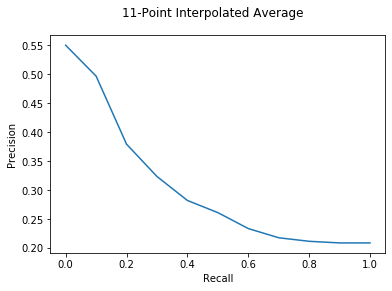

array([0.55033297, 0.49693559, 0.37925093, 0.32333963, 0.28188492,
       0.26087635, 0.23330272, 0.2173745 , 0.21126574, 0.2084731 ,
       0.2084731 ])

In [174]:
eleven_points_interpolated_avg(search_results, relevance)

Normalized Discounted Cumulative Gain

In [166]:
NDCG(search_results, relevance)

0.3535806928041176

pFound

In [167]:
pFound(search_results, relevance)

0.35553663160045385